In [1]:
import pandas as pd
import numpy as np
import re
import math

import requests, json
import pandas as pd

## 데이터 수집

In [2]:
NOTION_TOKEN = "secret_i10Ogxiao5uHQvkI6EpEflL9z2AVnU7PPxuDsKcHnUj"

headers = {
    "Authorization": "Bearer " + NOTION_TOKEN,
    "Content-Type": "application/json",
    "Notion-Version": "2022-06-28",
}

DATABASE_ID_LIST = ["db2b026a03f0442f828bc88dcdbf143c", "c238334399d54b10aad0bcb84cb77d5c", "bf7efa466c624f1ca200d05c5cf34f58", "2f0e230f82974dd09841ae871cb558f9", "b708c8576ea34bb385d24aedc5b1277b", "d6211c2113914ecc86332d4bb305a115", "a8b0289c72eb4daaa1063152eb5e787a", "73e5dc61f97f4f2095c0265f2dae70d8", "1a91276509b246dda4c170a248d096c2", "6a374753947e42f7aa57fac3a474b78f"]
YEAR_LIST = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

def readDatabase(DATABASE_ID_LIST, YEAR_LIST, headers):
    for id in zip(DATABASE_ID_LIST, YEAR_LIST):
        readUrl = f"https://api.notion.com/v1/databases/{id[0]}/query"
        res = requests.request("POST", readUrl, headers=headers)
        data = res.json()
        print(res.status_code)

        if res.status_code == 200:
            try:
                with open(f"./data/{id[1]}.json", 'w', encoding='utf8') as f:
                    json.dump(data, f, ensure_ascii=False)
            except:
                continue
            
readDatabase(DATABASE_ID_LIST, YEAR_LIST, headers)

200
200
200
200
200
200
200
200
200
200


## 데이터 정제

In [3]:
YEAR_LIST = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


def jsonToDataFrame(YEAR_LIST):
    temp = {}
    year_list = []
    name = []
    birth = []
    registered = []
    fullTime = []
    responsibilities = []
    career = []
    stock = []
    time1 = []
    time2 = []
    position = []

    for year in YEAR_LIST:
        with open(f"./data/{year}.json", 'r') as f:
            json_data = json.load(f)
            for i in range(len(json_data['results'])):
                properties = json_data['results'][i]['properties']
                year_list.append(year)
                for key in properties:
                    if key == '이름':
                        name.append(properties[key]['title'][0]['text']['content'])
                    elif key == '출생년월':
                        birth.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '등기임원 여부':
                        registered.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '상근 여부':
                        fullTime.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '담당업무':
                        responsibilities.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '주요경력':
                        career.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '의결권 있는 주식수':
                        stock.append(properties[key]['number'])
                    elif key == '재직기간':
                        time1.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '임기만료일':
                        time2.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '직위':
                        position.append(properties[key]['rich_text'][0]['text']['content'])

    temp['이름'] = name
    temp['연도'] = year_list
    temp['출생년월'] = birth
    temp['등기임원 여부'] = registered
    temp['상근 여부'] = fullTime
    temp['담당업무'] = responsibilities
    temp['주요경력'] = career
    temp['의결권 있는 주식수'] = stock
    temp['재직기간'] = time1
    temp['임기만료일'] = time2
    temp['직위'] = position
    return temp

dict = jsonToDataFrame(YEAR_LIST)

df = pd.DataFrame.from_dict(data=dict, orient='columns')

In [5]:
df['의결권 있는 주식수'].fillna(0.0, inplace=True)
#'\xa0' 처리
df['주요경력']=df['주요경력'].str.replace('\xa0', '')
#대학, 전공 피처 생성
temp=df['주요경력'].str.split('\n')
colleges=temp.str.get(0)

#추가로 처리해줘야될 대학 form 맞춰주기
colleges[colleges== 'University of Bath 사회과학대학원(석사)'] ='UniversityofBath 사회과학대학원(석사)'
colleges[colleges== 'Florida International University 경영대학원(박사)']='FloridaInternationalUniversity 경영대학원(박사)'
colleges[colleges== 'Ohio State University 정책대학원(박사)'] = 'OhioStateUniversity 정책대학원(박사)'
colleges[colleges== 'KDI국제정책대학원(석사)'] = 'KDI 국제정책대학원(석사)'
colleges[colleges== '상명여자사범대'] = '상명여자사범대 교육학'
colleges[colleges== '한국외국어대경영학(석사)'] = '한국외국어대 경영학(석사)'
colleges[colleges== '미시간대학교 경영대학원 MBA'] = '미시간대학교 경영대학원MBA'

#대학, 전공으로 나누기
ttemp = colleges.str.split() 

#대학 피처 생성
df['대학교']=ttemp.str.get(0)

#전공 피처 생성
tttemp = ttemp.str.get(1)
tttemp=tttemp.replace(r'\([^)]*\)', '', regex=True)
df['전공']=tttemp

#근속연수 생성
def create_work_years(x):
  temp = re.split(r'~|~\n', x)
  temp[0] = temp[0].strip()
  temp[1] = temp[1].strip()
  return int(temp[1][:4]) - int(temp[0][:4])

df['근속연수'] = df['재직기간'].apply(lambda x : create_work_years(x))

#주요경력 전처리
def replace_career(x):
  temp = [string.split() for string in re.split(r'\n |\n', x)]
  if len(temp)==1 :
    return {'대신증권'}
  else:
    return set(list(zip(*temp[1:]))[0])

df['주요경력요약'] = df['주요경력'].apply(lambda x : replace_career(x))

In [6]:
df_2014 = df[df['연도']==2014].reset_index(drop=True)
df_2015 = df[df['연도']==2015].reset_index(drop=True)
df_2016 = df[df['연도']==2016].reset_index(drop=True)
df_2017 = df[df['연도']==2017].reset_index(drop=True)
df_2018 = df[df['연도']==2018].reset_index(drop=True)
df_2019 = df[df['연도']==2019].reset_index(drop=True)
df_2020 = df[df['연도']==2020].reset_index(drop=True)
df_2021 = df[df['연도']==2021].reset_index(drop=True)
df_2022 = df[df['연도']==2022].reset_index(drop=True)
df_2023 = df[df['연도']==2023].reset_index(drop=True)

## 가중치(유사도) 계산

In [4]:
#학교 거리 계산
def cal_college(df1, df2, alpha = 0.7):
  #지역별로 나눔
  college_dict = {'서울경기':['상명여자사범대', '서울대', '홍익대', '성균관대', '연세대', '연세대학교', '동국대', '중앙대', '한국외대', '한국외국어대', '세종대학교', '세종대', '성균관대학교', '경희대', '서강대', '고려대', '건국대', '가천대', '가천대학교', '한양대', '명지대'],
                   '광역시':['부경대', '경북대', '전남대', '조선대', '한국과학기술원', '가천대', '인하대', '동아대', '대전대', '울산대', '영남공업전문대'],
                   '그외한국':['전북대', '원광대', '충북대', '충북대학교', '강원대', 'KDI'],
                   '해외':['FloridaInternationalUniversity', 'OhioStateUniversity', 'UniversityofBath', '조지아공대', 'Brown대', '카네기멜론대', '미시간대학교']}

  #키값 찾기
  for key, val in college_dict.items() :
    if df1['대학교'] in val :
      df1_key = key
    if df2['대학교'] in val :
      df2_key = key
          
  #k값 구하기
  if df1['대학교'] == df2['대학교'] :
    k=0
  elif df1_key == df2_key :
    k=1
  elif df1_key != df2_key :
    k=2

  return alpha ** k

#학과 거리 계산
def cal_department(df1, df2, alpha = 0.7):
  department_dict={'경영경제':['회계학', '세무학', '경제학', '국제경영학', '경영학', '무역학', 'MBA', '경제통상학', '경영대학원', '경영대학원MBA', '산업정보학', '금융공학', '국제금융학'],
                   '사회과학':['사회학', '사회과학대학원', '행정학', '정치외교학', '정치학', '신문방송학'],
                   '법률':['법학', '사법학', '정책대학원', '국제정책대학원'],
                   '인문':['불어불문학'],
                   '기타':['교육학', '인적자원개발학'],
                   '자연':['응용통계학', '통계학', '수학'],
                   '공학':['기계공학', '화학공학', '전자계산학', '전자전산학', '전산학', '항공우주학']}

  #키값 찾기
  for key, val in department_dict.items() :
    if df1['전공'] in val :
      df1_key = key
    if df2['전공'] in val :
      df2_key = key
          
  #k값 구하기
  if df1['전공'] == df2['전공'] :
    k=0
  elif df1_key == df2_key :
    k=1
  elif df1_key != df2_key :
    k=2

  return alpha ** k

#직위 거리 계산
def cal_position(df1, df2, alpha = 0.7):
  position_dict={'회장':0, '대표이사':1, '부회장':2, '사장':3, '부사장':4, '전무':5, '상무': 6, '상무보':7, '이사대우부문장':8, '이사대우담당':8, '사외이사':99, '감사위원':99}

  #value값 찾기
  df1_value = position_dict[df1['직위']]
  df2_value = position_dict[df2['직위']]

  #k값 구하기
  if df1['직위'] == df2['직위'] :
    k=0
  elif df1_value == 99 or df2_value == 99 : #사외이사 혹은 감사인원(회사밖 인물)은 모두와 거리 4(최대차이의 중간값// 회장, 이사대우담당과의 거리)
    k=4
  else :
    k=abs(df1_value - df2_value) #값 차이만큼 거리

  return alpha ** k

# 근속연수 거리 계산
def cal_work_years(df1, df2, alpha = 0.7):
  #k값 구하기
  if df1['근속연수'] == df2['근속연수'] :
    k=0
  else :
    if abs(df1['근속연수'] - df2['근속연수']) % 5 ==0:    #근속연수 차이 5년 기준으로 1씩 증가 (차이 1~5/6~10/11~15/...같은그룹)
      k= abs(df1['근속연수'] - df2['근속연수']) // 5 
    else:
      k= 1 + abs(df1['근속연수'] - df2['근속연수']) // 5 

  return alpha ** k  

#담당업무 거리 계산
def cal_task(df1, df2, alpha = 0.7):
  task_dict={'IT계열': {'IT':['IT부문장', 'IT본부장', 'IT서비스본부장', '디지털부문장', '스마트Biz본부장', 'Operation&Technology본부장'], '정보보호':['정보보호부문장', '정보보호담당']},
             '본사영업':{'Wolesale':['Wholesale부문장','Wholesale영업본부장', 'Wholesale사업단장', 'Trading부문장', 'Trading Center장', 'Sales&Trading총괄', '대외협력담당'], 
                     'IB':['IB사업단장', 'IB부문장', 'IB부부문장', 'IB1부문장', 'IB2부문장', 'IPO담당',  'PF부문장', 'PF1본부장', '구조화상품본부장'], 
                     '영업':['영업부장']},
             '본사관리':{'리테일':['리테일총괄', 'Club1962센터장','WM추진부문장', 'WM추진본부장', 'WM사업단장'],
                     '리스크':['리스크관리부문장', '리스크관리담당'] ,
                     '경영':['경영전략총괄', '전략지원부문장', '전략지원담당', '경영지원본부장', '경영지원부문장', '경영기획부문장', '경영기획본부장', '기획본부장', '기획본부장 / 투자금융담당', '전략지원부문장/프라이빗라운지 부문장'], 
                     '상품':['Product부문장', 'Solution&Product사업단장'],
                     '업무':['업무총괄',  '업무총괄(IB사업단, 고객자산본부 제외)', '업무총괄(IB사업단,고객자산본부 제외)', '업무총괄 (IB사업단,고객자산본부 제외)', '업무총괄(IB사업단, 고객자산본부, 경영지원본부, 정보보호부문, 준법지원부문, 감사부문 제외)'], 
                     '금융':['기업금융담당', '스마트금융본부장', '금융주치의추진본부장', '금융주치의사업단장'], 
                     '인사,인프라':['인재역량센터장', '인프라관리본부장'],
                     '법률':['준법감시인\n 준법지원부문장', '준법감시인 준법지원부문장', '준법감시인\n준법지원부문장', '준법감시인\n준법지원담당', '준법감시인/준법지원부문장', '준법감시인 / 준법지원담당', 'Advisory본부장'], 
                     '감사':['감사위원장', '감사부문장', '감사위원', '상근감사위원', '감사담당'], 
                     '언론홍보':['홍보부문장', 'Coverage본부장']},
             '리서치': {'리서치센터':['Research Center장', '리서치센터장', 'Market\n  Solution부문장', 'Research&Strategy본부장', 'Market Solution부문장', 'Market Solution 부문장']},
             '고객':{'고객자산':['고객자산부문장', '고객자산부문 부부문장', '고객자산본부장', '고객자산본부장 / 홍보담당', '고객자산본부장/ 홍보담당', '고객자산본부장/ 홍보부문장', '고객자산본부장/홍보부문장', '고객자산부문장, 홍보부문장', '고객자산부문장\n홍보부문장'],
                   'WM':['서부WM부문장', '서부WM본부장', '재경1WM부문장', '재경1WM본부장', '재경2WM본부장', '재경2WM부문장', '동부WM부문장', '동부WM본부장'],
                   '프라이빗':['프라이빗부문장,\n 나인원프라이빗라운지장', '프라이빗부문장, 나인원프라이빗라운지장', '대신나인원 \n프라이빗라운지장', '프라이빗라운지 부문장 /대신나인원 프라이빗라운지장', '프라이빗부문장, 대신나인원프라이빗라운지장', '프라이빗부문장\n나인원프라이빗라운지장',], 
                   '소비자보호':['금융소비자보호부문장\n(COO)', '금융소비자보호부문장(COO)', '금융소비자보호부문장 (COO)', '금융소비자보호 총괄', '금융소비자보호총괄']},
             '기타':{'지점':['강북지역본부장', '강남지역본부장', '강남선릉센터장', '서부지역본부장', '동부지역본부장', '울산지점장'],
                   '비서':['비서실장', '비서/브랜드본부', '비서/브랜드담당'], '공란':['-']}}

   #키값 찾기
  for outerKey in task_dict.keys() :
    for key, val in task_dict[outerKey].items() :
      if df1['담당업무'] in val :
        df1_outerKey = outerKey
        df1_innerKey = key
      if df2['담당업무'] in val :
        df2_outerKey = outerKey
        df2_innerKey = key
          
          
  #k값 구하기
  if df1['담당업무'] == df2['담당업무'] : #같은업무
    k=0
  elif df1_outerKey == df2_outerKey and df1_innerKey == df2_innerKey: #상위하위 혹은 비슷한업무
    k=1
  elif df1_outerKey == df2_outerKey : #같은계열업무
    k=2
  elif df1_outerKey != df2_outerKey :
    k=3 #다른계열업무
  return alpha ** k

#경력 거리 계산
def cal_career(df1, df2, alpha = 0.7):
  career_dict={1:['대신증권', '대신증권WM사업단장', 'WM추진부문장', '재경1WM부문장', '대신증권중부지역본부장', '기획본부장대신증권', '대신증권분당지점장', '대신증권무거동지점장', '대신증권Capital', 
                  '이사대우부본부장', '기획본부장대신증권인재역량센터장', '대신증권인재전략부', '대신증권파생상품운용부장', '대신증권자산운용본부', '대신증권영업기획부장', '대신증권기획실장', 
                  '대신증권홍보실', '대신증권브랜드전략실', '대신증권IT개발부장', '대신증권트레이딩시스템부장', '대신증권Global사업본부', '신증권', '기업금융사업단장'], #대신증권
               0:['대신에프앤아이', '대신투자신탁운용', '대신투자신탁운용상무이사', '대신에이엠씨', '대신자산운용', '대신저축은행'], #대신증권 자회사
               2:['메리츠종금증권', '메리츠증권', '미래에셋증권', 'KTB투자증권', 'SC제일은행', '하나금융투자', 'IBK투자증권', 'DB금융투자', 'NH투자증권', 'KB증권', 'LIG손해보험', '굿모닝신한증권', '메릴린치증권', 
                  '삼성증권', '동양증권', '한국투자증권', '한국투자증권평촌지점', '대우증권', '대우본부장', '대우증권전략기획본부', '대우증권해외사업부문', '대우증권IB사업부문', 
                  '우리투자증권', '우리CS자산운용', '우리투자증권기업금융2팀장', '우리프라이빗에쿼티', '푸르덴셜투자증권', '하이투자증권주식인수팀',  '하이투자증권주식인수팀', 'SBC', 'Bank', '도이치은행'], #타증권사
               3:['금융감독원', '금융위원회', '現)금융위원회', '감사원', '대검찰청', '법무법인', '現)법무법인', '세무법인', '국세청', '중부지방국세청', '서울북부지방검찰청','서울지방국세청장', '서울지방국세청', 
                  '제58대', '제22대', '기획재정부', '국세청,관세청,산업통상자원부', '자본시장연구원', '한국조세연구원', '국가청렴위원회', '대한중재인협회', '한국회계정보학회', 
                  '금융위원회금융발전심의위원(현)', '금융위원회적극행정심의위원(現)', '안진회계법인',  'L&C세무회계사무소', '변호사정상명법률사무소', '피앤비세무컨설팅', '現)법무법인(유)'], #법,정책
               4:['중앙대', '중앙대학교', '現)중앙대', '연세대학교', 'KAIST', '수원대', '수원대학교', '서울시립대', '現)서울시립대', '학교법인', '現)학교법인', '재단법인', '現)재단법인'], #학교, 교수, 재단
               5:['하비스트', '한국물산', '우리선물', '부영주택', 'LG경제연구원', 'Arthur'] #기타
               }
  
  #경력 여부 빈리스트 생성
  df1_list = [0,0,0,0,0,0] #0번인덱스: 대신증권, 1번인덱스: 대신증권 자회사, 2번인덱스: 타증권사, 3번인덱스: 기타
  df2_list = [0,0,0,0,0,0]

  #리스트에 각 업종에 종사했었으면 1, 아니면 0
  for career in df1['주요경력요약'] :
    for key, val in career_dict.items() :
      if career in val :
        df1_list[key]=1

  for career in df2['주요경력요약'] :
    for key, val in career_dict.items() :
      if career in val :
        df2_list[key]=1

  #df1_list 와 df2_list 합 구하기(요소가 0-> 둘다 종사 안했음, 1-> 한쪽만 종사함, 2-> 둘다 종사함)
  sum_list = [x + y for x, y in zip(df1_list, df2_list)]

  #k값 구하기
  if df1_list == df2_list : #전체 같으면 0
    k=0

  elif (sum_list[0]==0 and sum_list[1]==0 and sum_list[2]==0): #기타만 있을 때 (법률, 학교, 기타) 
    count2 = sum_list.count(2) #2인 요소 개수 찾기(df1, df2 같은거 개수)
    k = 0.6 * (1 + count2)

  else : #기타만 있는거 아니고, 
    #법률, 학교, 기타 전부 기타로 통합. 범주는 3으로.
    if sum(df1_list[3:]) > 0 :
      df1_list[3] = 1
      df1_list[4] = 0
      df1_list[5] = 0
    if sum(df2_list[3:]) > 0 :
      df2_list[3] = 1
      df2_list[4] = 0
      df2_list[5] = 0

    #수정한 df1_list, df2_list로 sum_list 다시 생성
    sum_list = [x + y for x, y in zip(df1_list, df2_list)]

    #df1_list, df2_list에서 1인 인덱스 뽑기
    index1 = [i for i in range(len(df1_list)) if df1_list[i] == 1]
    index2 = [i for i in range(len(df2_list)) if df2_list[i] == 1]

    min = 10
    max = 0

    for i in index1 :
      for j in index2 :
        if i != j: #두 사람 간에, 다른 업종끼리 최대거리 최소 거리 구하기

          if (i==3 and j != 3) or (j==3 and i != 3) : #기타와 다른 업종
            max = 4 #기타는 모두와 거리 4 고정 (최대거리 구하기)
            temp = 4
          else : #최대거리 구하기
            temp = abs(i-j)
            if temp > max:
              max = temp
          if temp < min: #최소거리 구하기
            min = temp
    
    k=float((max+min)/2) #거리는 최대거리, 최소거리의 평균
    k= k- (0.5 * sum_list.count(2)) # 같은 업종 있으면, 있는 만큼 거리 -0.5
  
  return alpha ** k

#보유 주식수별 거리 계산
def cal_stock(df1, df2, alpha = 0.7):
  #k값 구하기
  if df1['의결권 있는 주식수'] == df2['의결권 있는 주식수'] :
    k=0
  else :
    k= abs(df1['의결권 있는 주식수'] - df2['의결권 있는 주식수'])//100 #차이로 보기=> 차이가 거리가 됨(너무 차이 크면 거리 멀어짐), 100개 단위로 끊어서 보기
    k=math.log10(1+k) #로그스케일
  return alpha ** k  

In [5]:
#가중치 함수
def weight_sum(df1, df2):
  wt_college = cal_college(df1, df2)
  wt_department = cal_department(df1, df2)
  wt_position = cal_position(df1, df2)
  wt_task = cal_task(df1, df2)
  wt_work_years = cal_work_years(df1, df2)
  wt_career = cal_career(df1, df2)
  wt_stock = cal_stock(df1, df2)
  return wt_college + wt_department + wt_position + wt_task + wt_work_years + wt_career + wt_stock

In [6]:
# 인물 가중치행렬
col = []
row = []
matrixs = []
dataFrames = [df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023]

for dataframe in dataFrames:
  for i in range(len(dataframe)):
      col.append(dataframe.loc[i, '이름'])
      row.append(dataframe.loc[i, '이름'])
  weight_matrix = pd.DataFrame(columns=col, index=row)
  matrixs.append(weight_matrix)
  col=[]
  row=[]

In [7]:
#가중치 계산
for t, dataframe in enumerate(dataFrames):
  for i in range(0, len(dataframe)):
    for j in range(0, len(dataframe)):
      matrixs[t].iloc[i, j] = round(weight_sum(dataframe.iloc[i], dataframe.iloc[j])**2, 2)

## 관심 인물 선정

In [9]:
# 대신증권 연간 재무 정보
daishin_Annual_Financial_Info = pd.read_csv('data/daishin_Annual_Financial_Info.csv', sep=",", encoding='UTF-8')
profit_avg = daishin_Annual_Financial_Info['연도별 누적 순이익 (단위:천원)'].mean()

def find_promoted_employees(df, daishin_Annual_Financial_Info):
    increased_years = []  # 매출이 증가한 연도를 담을 리스트
    promoted_employees = []  # 승진 또는 입사한 인물을 담을 리스트

    # 매출액이 증가한 연도 찾기
    for index, row in daishin_Annual_Financial_Info.iterrows():
        if row['연도별 누적 순이익 (단위:천원)'] > profit_avg:
            increased_years.append(row['연도'])

    for year in increased_years:
        for index, row in df.iterrows():
            if row['연도'] == year:
                previous_year = year - 1

                previous_row = df.loc[df['연도'] == previous_year]
                start_year = int(row['재직기간'].split('.')[0])
                
                # 입사 여부 확인
                if start_year == year:
                    promoted_employees.append(row['이름'])
                
                # 직위 변화 확인
                elif len(previous_row) > 0 and row['직위'] != previous_row['직위'].values[0]:
                    promoted_employees.append(row['이름'])

    return promoted_employees

promoted_employees = find_promoted_employees(df, daishin_Annual_Financial_Info)

def find_increased_stockholders(df, daishin_Annual_Financial_Info):
    increased_years = []  # 매출이 증가한 연도를 담을 리스트
    increased_stockholders = []  # 주식보유량이 증가한 인물을 담을 리스트

    # 매출액이 증가한 연도 찾기
    for index, row in daishin_Annual_Financial_Info.iterrows():
        if row['연도별 누적 순이익 (단위:천원)'] > profit_avg:
            increased_years.append(row['연도'])

    for year in increased_years:
        for index, row in df.iterrows():
            if row['연도'] == year:
                previous_year = year - 1

                # 주식보유량 변화 확인
                previous_row = df.loc[df['연도'] == previous_year]
                if len(previous_row) > 0 and row['의결권 있는 주식수'] > previous_row['의결권 있는 주식수'].values[0]:
                    increased_stockholders.append(row['이름'])

    return increased_stockholders

increased_stockholders = find_increased_stockholders(df, daishin_Annual_Financial_Info)

important_person = promoted_employees + increased_stockholders

from collections import Counter

counter = Counter(important_person)

# 등장 횟수가 많은 순서대로 정렬된 튜플 리스트 생성
sorted_elements = sorted(counter.items(), key=lambda x: x[1], reverse=True)

# 정렬된 리스트에서 요소와 등장 횟수 출력
for element, count in sorted_elements:
    print(f'{element}: {count}')

양홍석: 8
이어룡: 7
홍대한: 6
송혁: 6
이순남: 5
김상원: 5
오익근: 5
김범철: 5
신인식: 4
조경순: 4
박성준: 4
정연규: 4
진승욱: 4
김성원: 4
권택현: 4
김호중: 4
이정화: 4
이재우: 4
박현식: 4
나유석: 4
신재범: 4
홍종국: 4
나재철: 3
박동현: 3
이동훈: 3
김병철: 3
정재중: 3
강윤기: 3
임민수: 3
정기동: 3
김수창: 3
최근영: 3
정연우: 3
강준규: 3
박규상: 2
하창룡: 2
장우철: 2
신재국: 2
김재중: 2
최명재: 2
배영훈: 2
이창세: 2
이지원: 2
문병식: 2
이성영: 2
김봉진: 2
길기모: 2
정상명: 1
김창봉: 1
김경찬: 1
김경식: 1
정태영: 1
한여선: 1
권인섭: 1
박찬수: 1
이인형: 1
정태암: 1
이환목: 1
최정석: 1
이문수: 1
이득원: 1
조홍희: 1
원윤희: 1
이정훈: 1
박정환: 1
유창범: 1
김창수: 1
유승덕: 1
김송규: 1
조윤남: 1
이현식: 1


In [10]:
def select_important_people(sorted_elements, threshold=2):   # threshold 이상 등장한 인물을 리스트로 반환
    import_p = []
    for element, count in sorted_elements:
        if count >= threshold:
            import_p.append(element)
    return import_p

In [11]:
major_p = select_important_people(sorted_elements, 2)
print(major_p)

['양홍석', '이어룡', '홍대한', '송혁', '이순남', '김상원', '오익근', '김범철', '신인식', '조경순', '박성준', '정연규', '진승욱', '김성원', '권택현', '김호중', '이정화', '이재우', '박현식', '나유석', '신재범', '홍종국', '나재철', '박동현', '이동훈', '김병철', '정재중', '강윤기', '임민수', '정기동', '김수창', '최근영', '정연우', '강준규', '박규상', '하창룡', '장우철', '신재국', '김재중', '최명재', '배영훈', '이창세', '이지원', '문병식', '이성영', '김봉진', '길기모']


### 네트워크 시각화

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#중심성 정규화 함수
def normalize_centrality(centrality_dict):        # 중심성들 0 ~ 1 값으로 정규화
    max_value = max(centrality_dict.values())
    min_value = min(centrality_dict.values())
    normalized_centrality = {node: (value - min_value) / (max_value - min_value) for node, value in centrality_dict.items()}
    return normalized_centrality


def print_network(matrixs):
    #연도별로 중심값 저장할 dic
    result_dict_all_year ={}
    year = 2013
    for k in range(len(matrixs)):
        year += 1
        node = matrixs[k].columns.tolist()
        # 특정 임계값보다 작은 가중치를 가진 간선은 표시하지 않음 (centrality 계산을 위해 다시 아래 코드를 삽입한것임)
        m_w_sum = []
        for i in range(len(matrixs[k])):
            for j in range(len(matrixs[k])):
                m_w_sum.append(matrixs[k].iloc[i, j])

        threshold = np.percentile(m_w_sum, 80)
        node = matrixs[k].columns.tolist()
        # 그래프에 노드와 간선 삽입
        G = nx.Graph()
        G.add_nodes_from(node)
        for i in range(len(node)):
            for j in range(i + 1, len(node)):
                weight = matrixs[k].iloc[i, j]
                if weight >= threshold:  # 특정 임계값 이상인 경우에만 add_edge
                    G.add_edge(node[i], node[j], weight=matrixs[k].iloc[i,j])
        plt.figure(figsize=(12, 20))
        plt.rcParams['font.family'] = 'AppleGothic'
        pos = nx.spring_layout(G, k=3.0)  # 레이아웃 설정
        node_colors = ['red' if n in major_p else 'lightblue' for n in G.nodes()]  # major_p에 해당하는 노드는 빨간색, 나머지는 파란색으로 설정
        weights = [G[u][v]['weight'] for u, v in G.edges()]  # 엣지의 가중치 리스트
        
        degree_centrality = nx.degree_centrality(G)
        node_sizes = [250 if degree_centrality[n] * 10000 <= 50 else degree_centrality[n] * 15000 for n in G.nodes()]   # degree centrality에 따라 노드 크기 조정
        
        nx.draw_networkx(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color='gray', width=1.0, font_family='AppleGothic')
        
        # 가중치에 따른 엣지 라벨 추가
        # labels = nx.get_edge_attributes(G, 'weight')
        # nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)              가중치를 표시하려면 주석 처리 x
        
        

        # Create legend handles and labels
        legend_handles = [
            mpatches.Patch(color='red', label='중요인물'),
            mpatches.Patch(color='lightblue', label='일반인물')
        ]
        plt.legend(handles=legend_handles)
        plt.title('{0}년도 네트워크'.format(2014+k), color='blue', fontsize=16)
        plt.show()
        
        # 각 인물들이 중요 인물과 얼마나 연결되어있는지 출력
        sorted_nodes = sorted(G.nodes(), key=lambda n: sum(1 for neighbor in G.neighbors(n) if neighbor in major_p), reverse=True)
    
        # 노드와 중요인물과의 연결 개수를 포함하는 딕셔너리 생성
        node_connections = {n: sum(1 for neighbor in G.neighbors(n) if neighbor in major_p) for n in sorted_nodes}

        # 딕셔너리 출력
        # for node, connections in node_connections.items():
        #     print(f"{node}은 중요인물과 {connections}개 연결됨")

        # 중심성 계산
        degree_centrality = nx.degree_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        closeness_centrality = nx.closeness_centrality(G)
        eigenvector_centrality = nx.eigenvector_centrality(G)

        #정규화
        normalized_node_connections = normalize_centrality(node_connections)
        normalized_degree_centrality = normalize_centrality(degree_centrality)
        normalized_betweenness_centrality = normalize_centrality(betweenness_centrality)
        normalized_closeness_centrality = normalize_centrality(closeness_centrality)
        normalized_eigenvector_centrality = normalize_centrality(eigenvector_centrality)
                        
        # 딕셔너리 키 순서를 정렬하기 위한 공통 키 리스트 생성
        common_keys = sorted(node_connections.keys())

        result_dict = {}
        for node in common_keys:
            result_dict[node] = [normalized_node_connections[node], normalized_degree_centrality[node], normalized_betweenness_centrality[node], normalized_closeness_centrality[node], normalized_eigenvector_centrality[node]]


        #해당 연도의 중심성 값 저장
        result_dict_all_year[year] = result_dict
        
        # 결과 출력
        print("{0}년도 네트워크 점수 계산".format(2014+k))
        print()
        print("중요인물 연결 수")
        for node, centrality in sorted(node_connections.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Degree Centrality:")
        for node, centrality in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Betweenness Centrality:")
        for node, centrality in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Closeness Centrality:")
        for node, centrality in sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Eigenvector Centrality:")
        for node, centrality in sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        
    return result_dict_all_year

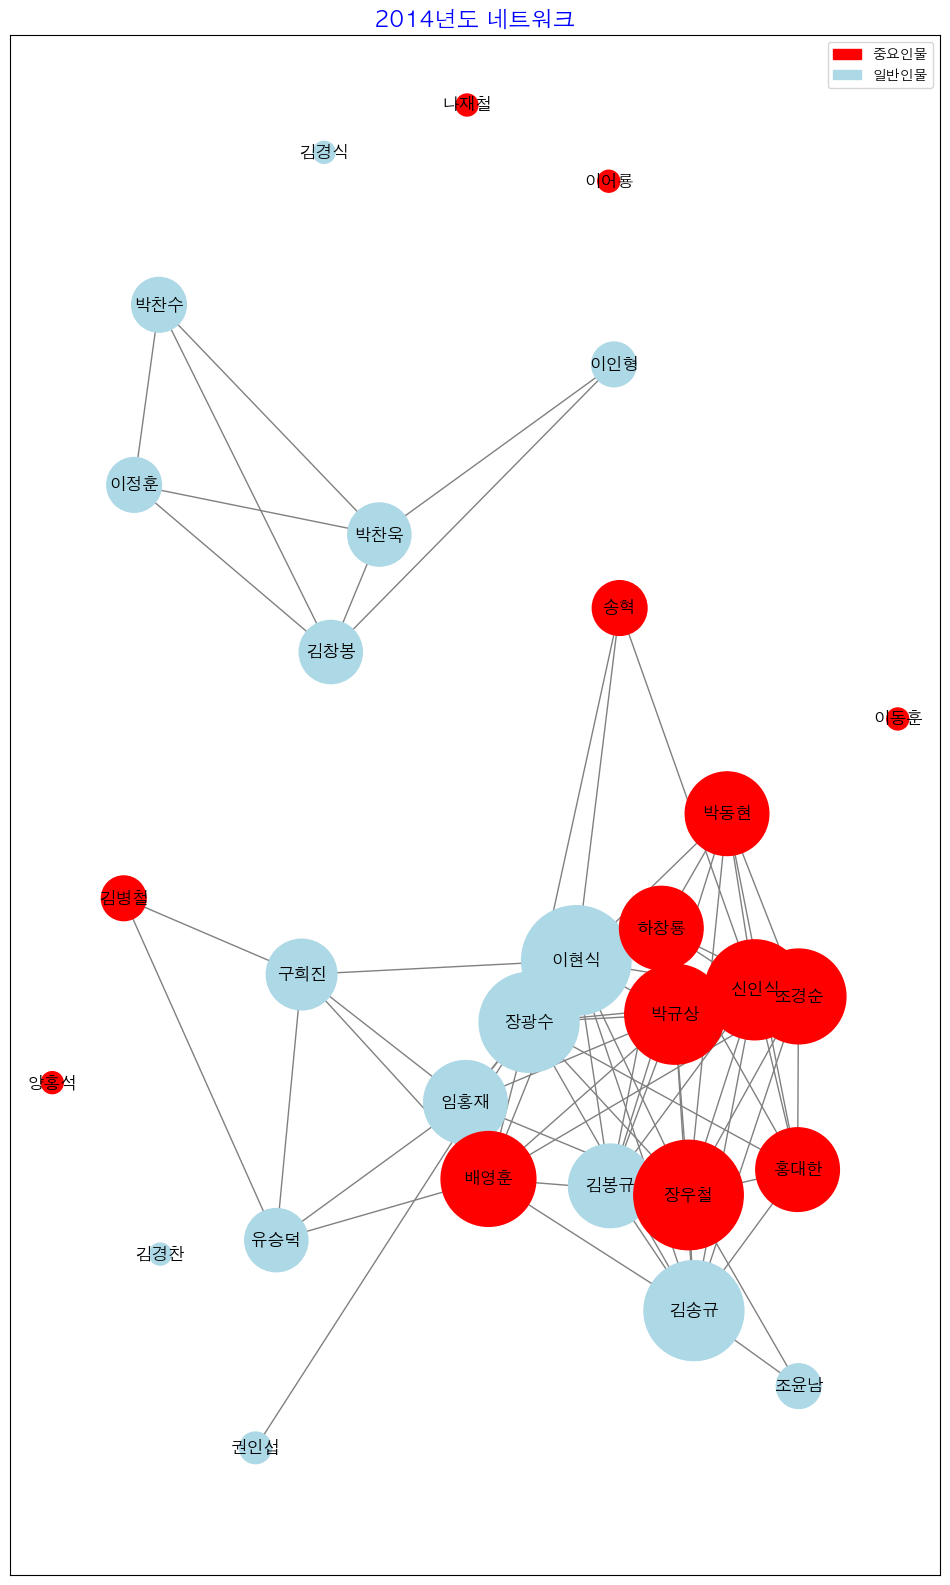

2014년도 네트워크 점수 계산

중요인물 연결 수
이현식 7
신인식 7
조경순 7
김송규 6
장광수 6
장우철 6
하창룡 5
박동현 5
홍대한 5
박규상 5
김봉규 5
임홍재 3
배영훈 3
구희진 2
유승덕 2
조윤남 1
송혁 1
나재철 0
이정훈 0
이동훈 0
박찬수 0
김경식 0
김경찬 0
권인섭 0
이어룡 0
양홍석 0
김병철 0
김창봉 0
박찬욱 0
이인형 0

Degree Centrality:
이현식 0.41379310344827586
장우철 0.41379310344827586
신인식 0.3448275862068966
박규상 0.3448275862068966
김송규 0.3448275862068966
장광수 0.3448275862068966
조경순 0.3103448275862069
배영훈 0.3103448275862069
하창룡 0.24137931034482757
박동현 0.24137931034482757
홍대한 0.24137931034482757
임홍재 0.24137931034482757
김봉규 0.24137931034482757
구희진 0.1724137931034483
유승덕 0.13793103448275862
김창봉 0.13793103448275862
박찬욱 0.13793103448275862
이정훈 0.10344827586206896
송혁 0.10344827586206896
박찬수 0.10344827586206896
조윤남 0.06896551724137931
김병철 0.06896551724137931
이인형 0.06896551724137931
권인섭 0.034482758620689655
나재철 0.0
이동훈 0.0
김경식 0.0
김경찬 0.0
이어룡 0.0
양홍석 0.0

Betweenness Centrality:
이현식 0.06442713690250637
장광수 0.0572728516694034
장우철 0.04111044948483372
배영훈 0.04057881773399015
구희진 0.03192391899288451
김송규 0.02368

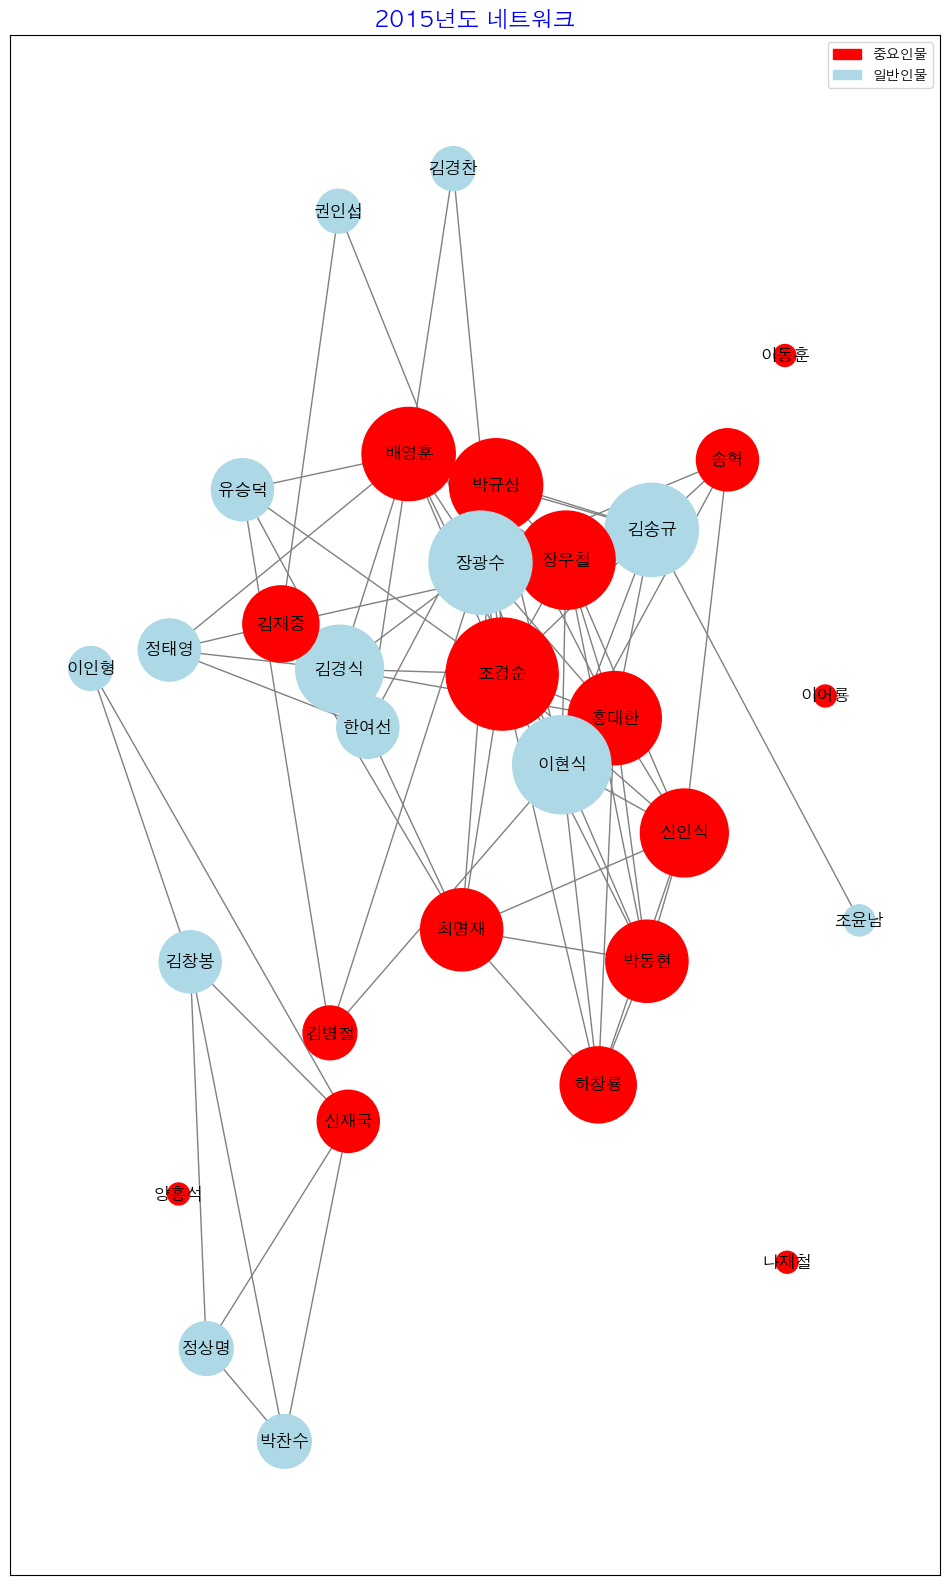

2015년도 네트워크 점수 계산

중요인물 연결 수
이현식 8
조경순 8
장우철 7
신인식 7
장광수 7
김송규 6
홍대한 6
박동현 6
최명재 6
박규상 5
하창룡 5
김경식 5
유승덕 3
배영훈 3
정태영 2
한여선 2
김재중 2
정상명 1
김창봉 1
김경찬 1
송혁 1
권인섭 1
박찬수 1
이인형 1
김병철 0
양홍석 0
나재철 0
조윤남 0
이어룡 0
이동훈 0
신재국 0

Degree Centrality:
조경순 0.43333333333333335
장광수 0.36666666666666664
장우철 0.3333333333333333
이현식 0.3333333333333333
박규상 0.3
김송규 0.3
배영훈 0.3
홍대한 0.3
김경식 0.26666666666666666
신인식 0.26666666666666666
박동현 0.23333333333333334
최명재 0.23333333333333334
하창룡 0.2
김재중 0.2
김창봉 0.13333333333333333
유승덕 0.13333333333333333
정태영 0.13333333333333333
한여선 0.13333333333333333
신재국 0.13333333333333333
송혁 0.13333333333333333
정상명 0.1
김병철 0.1
박찬수 0.1
김경찬 0.06666666666666667
권인섭 0.06666666666666667
이인형 0.06666666666666667
조윤남 0.03333333333333333
양홍석 0.0
나재철 0.0
이어룡 0.0
이동훈 0.0

Betweenness Centrality:
조경순 0.07797847108191935
장광수 0.062451195037401944
김송규 0.05381773399014779
이현식 0.03632731253420908
박규상 0.0331317277869002
배영훈 0.03031289910600255
장우철 0.026174968071519797
김경식 0.025883962780514504
김재중 0.02291735

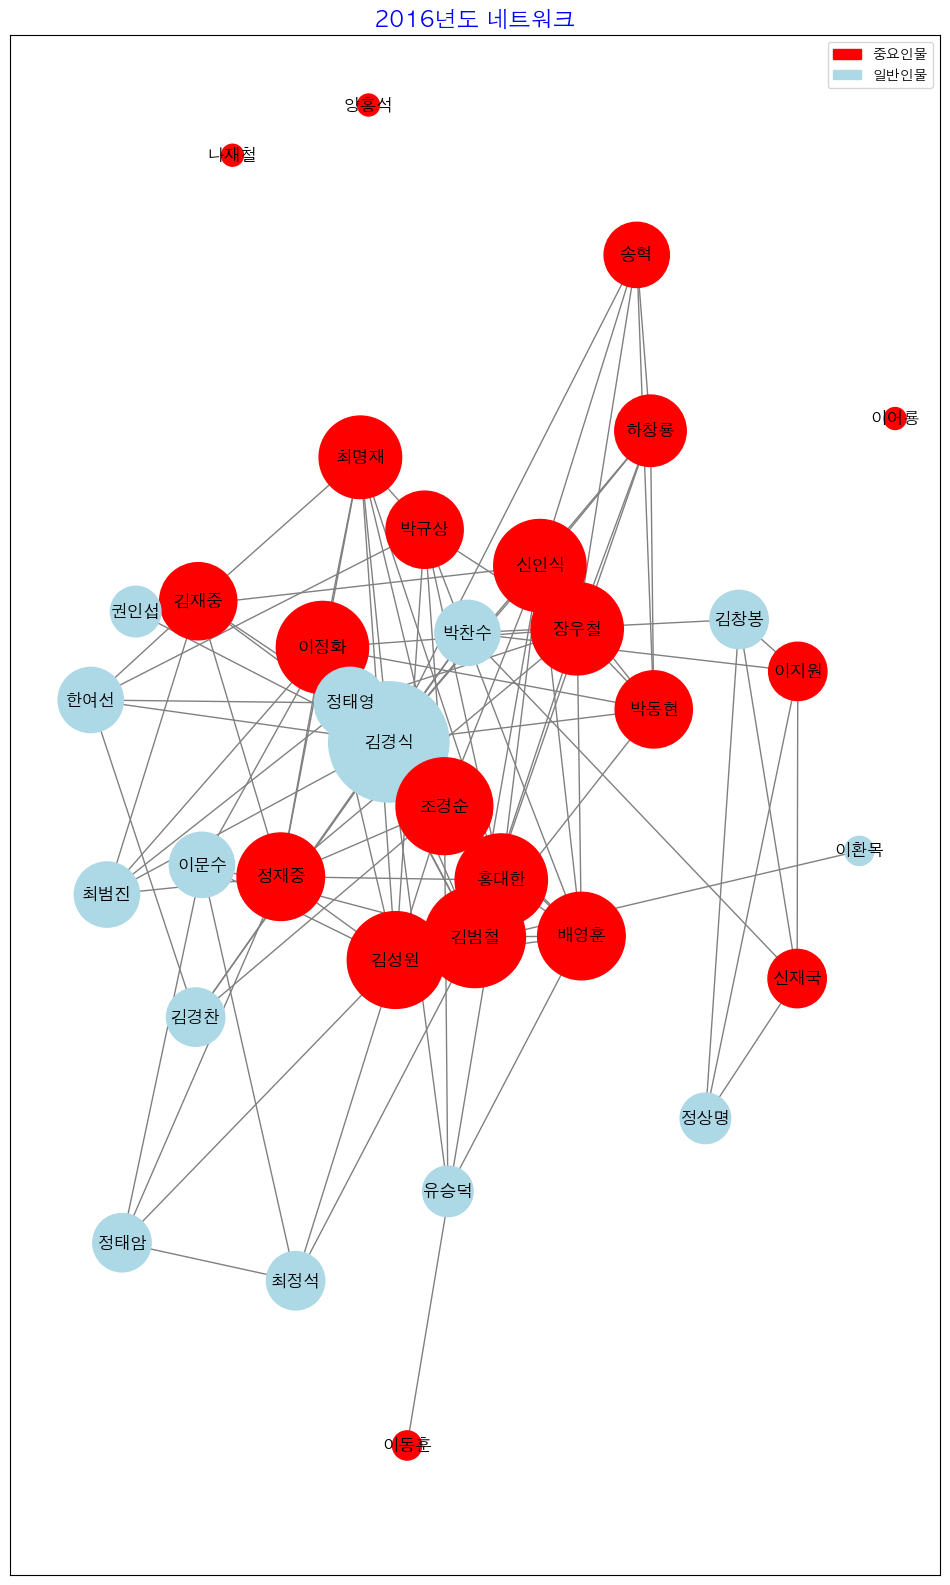

2016년도 네트워크 점수 계산

중요인물 연결 수
김경식 10
홍대한 9
장우철 9
이정화 8
신인식 8
김범철 8
조경순 8
최명재 7
김성원 7
정재중 7
배영훈 7
박동현 6
박규상 6
하창룡 5
송혁 4
이문수 3
정태영 3
최범진 3
김재중 2
정태암 2
권인섭 2
최정석 2
유승덕 2
정상명 2
박찬수 2
한여선 2
김창봉 2
신재국 1
이환목 1
김경찬 1
이동훈 1
이지원 1
이어룡 0
나재철 0
양홍석 0

Degree Centrality:
김경식 0.5
김범철 0.3529411764705882
김성원 0.3235294117647059
조경순 0.3235294117647059
이정화 0.29411764705882354
신인식 0.29411764705882354
홍대한 0.29411764705882354
장우철 0.29411764705882354
정재중 0.2647058823529412
배영훈 0.2647058823529412
최명재 0.23529411764705882
김재중 0.20588235294117646
박동현 0.20588235294117646
박규상 0.20588235294117646
정태영 0.1764705882352941
하창룡 0.1764705882352941
송혁 0.14705882352941177
이문수 0.14705882352941177
박찬수 0.14705882352941177
한여선 0.14705882352941177
최범진 0.14705882352941177
신재국 0.11764705882352941
정태암 0.11764705882352941
김경찬 0.11764705882352941
최정석 0.11764705882352941
김창봉 0.11764705882352941
이지원 0.11764705882352941
권인섭 0.08823529411764705
유승덕 0.08823529411764705
정상명 0.08823529411764705
이환목 0.029411764705882353
이동훈 0.02941176470588

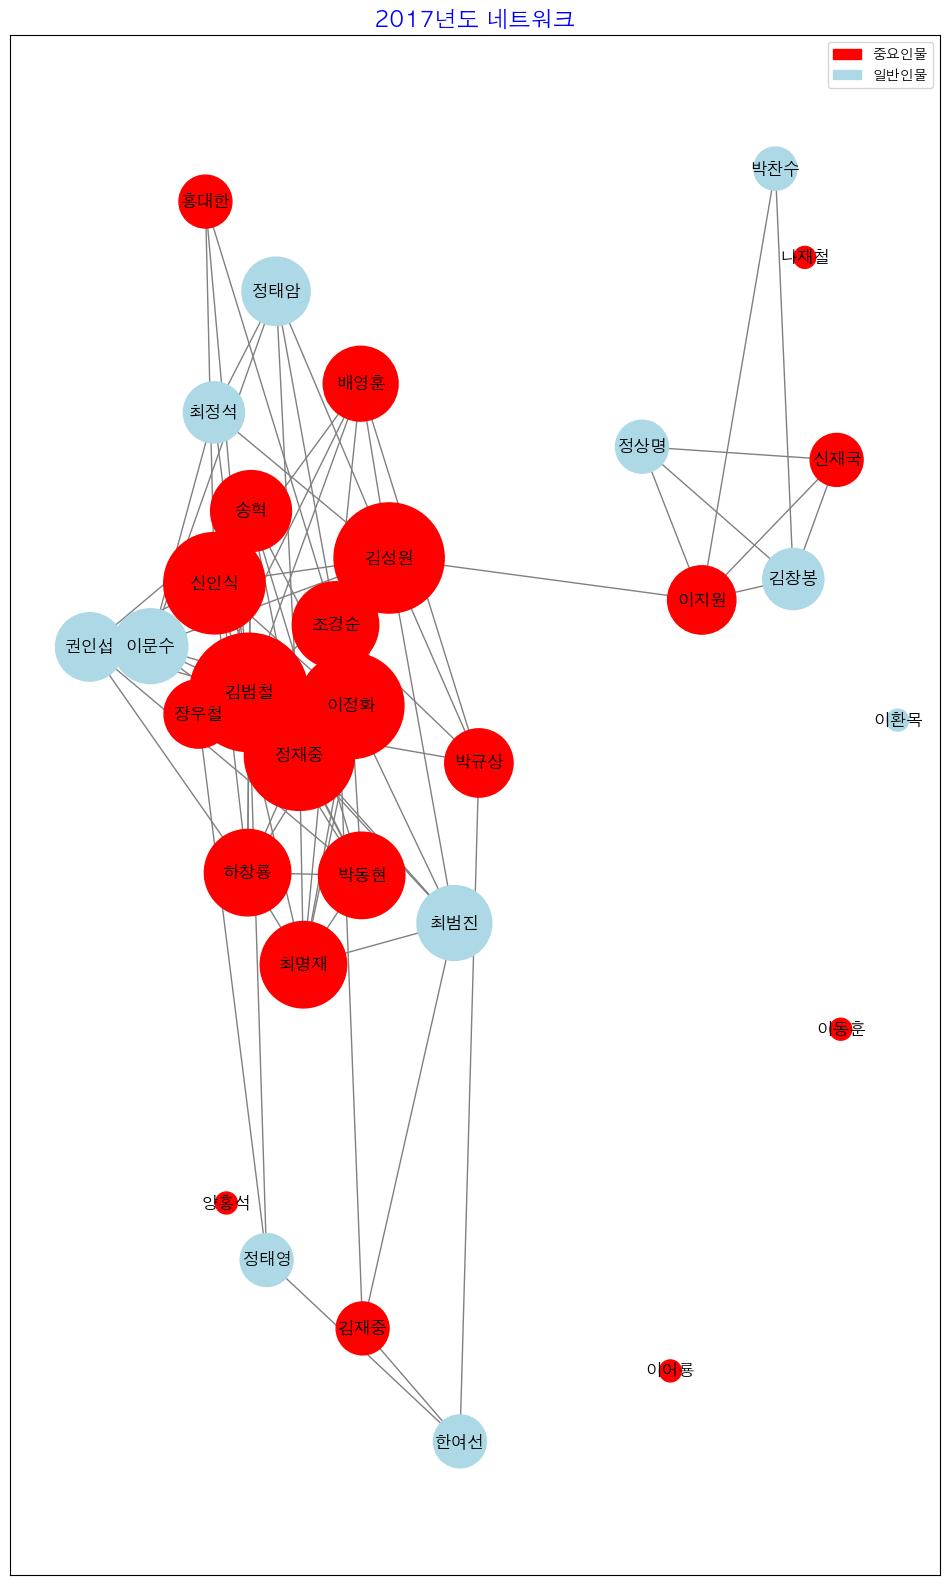

2017년도 네트워크 점수 계산

중요인물 연결 수
김범철 10
신인식 10
정재중 10
김성원 9
이정화 9
조경순 8
박동현 7
하창룡 7
최명재 7
최범진 6
송혁 6
배영훈 6
권인섭 5
이문수 4
장우철 4
박규상 4
정태암 3
홍대한 3
정태영 2
김창봉 2
이지원 2
최정석 2
정상명 2
한여선 2
김재중 1
박찬수 1
신재국 1
이어룡 0
이동훈 0
이환목 0
나재철 0
양홍석 0

Degree Centrality:
김범철 0.4838709677419355
김성원 0.4193548387096774
정재중 0.4193548387096774
이정화 0.3870967741935484
신인식 0.3548387096774194
박동현 0.25806451612903225
조경순 0.25806451612903225
하창룡 0.25806451612903225
최명재 0.25806451612903225
송혁 0.22580645161290322
최범진 0.1935483870967742
배영훈 0.1935483870967742
이문수 0.1935483870967742
정태암 0.16129032258064516
이지원 0.16129032258064516
장우철 0.16129032258064516
박규상 0.16129032258064516
권인섭 0.16129032258064516
김창봉 0.12903225806451613
최정석 0.12903225806451613
김재중 0.0967741935483871
정태영 0.0967741935483871
정상명 0.0967741935483871
홍대한 0.0967741935483871
신재국 0.0967741935483871
한여선 0.0967741935483871
박찬수 0.06451612903225806
이어룡 0.0
이동훈 0.0
이환목 0.0
나재철 0.0
양홍석 0.0

Betweenness Centrality:
김성원 0.276342138337045
이지원 0.1913978494623656
김범철 0.14409686

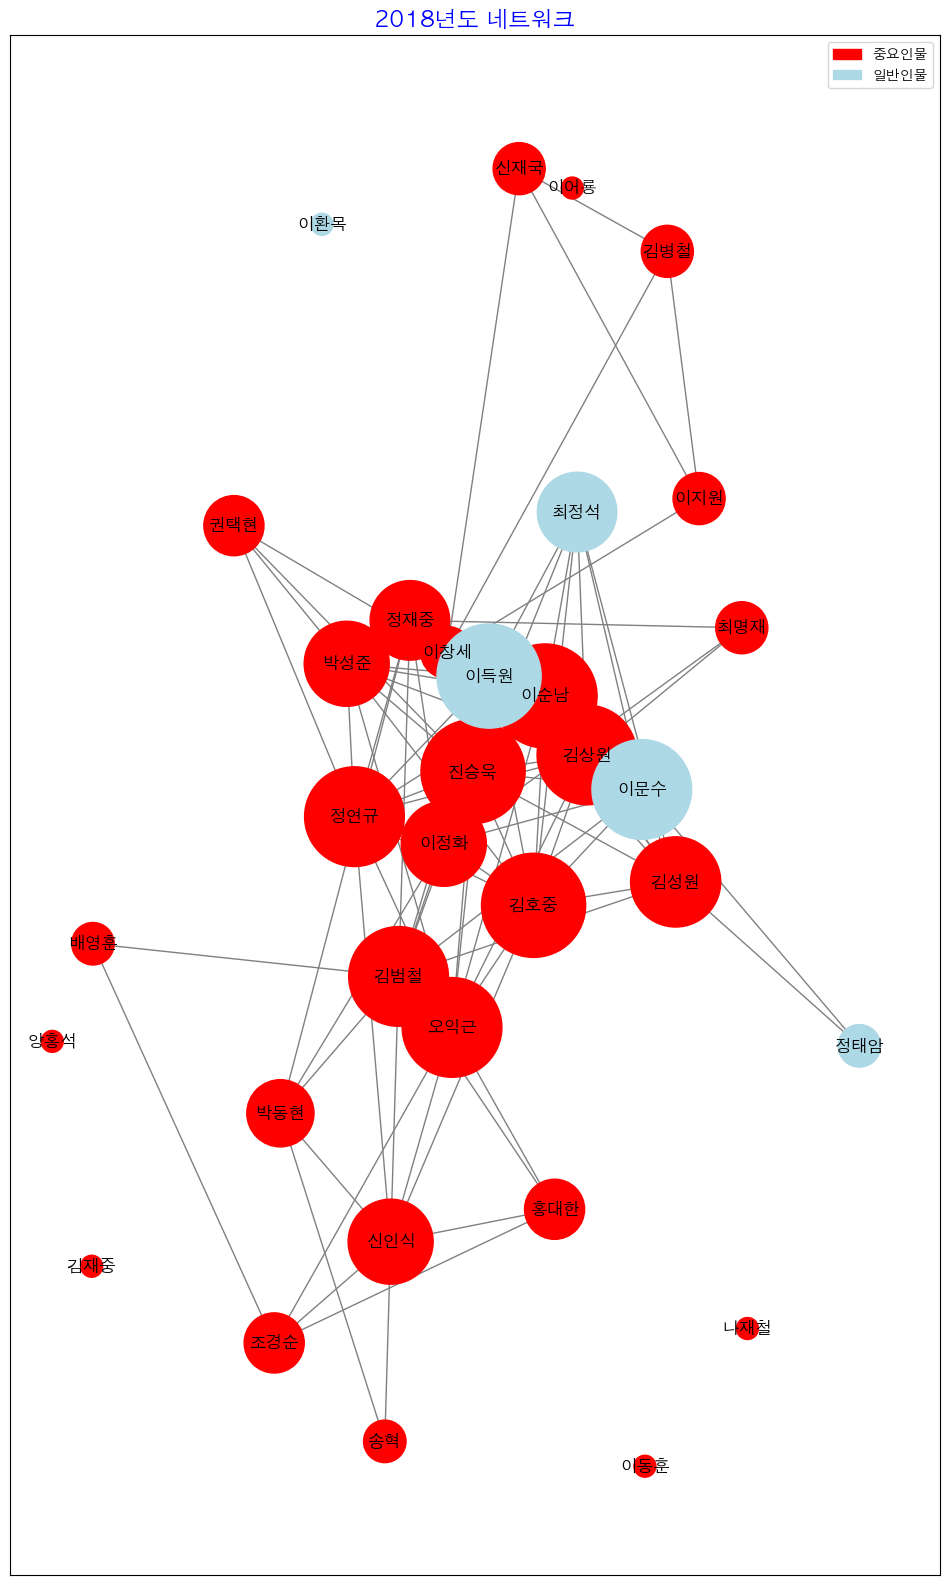

2018년도 네트워크 점수 계산

중요인물 연결 수
정연규 10
오익근 10
이득원 10
이순남 9
진승욱 9
김호중 9
김범철 9
김상원 8
이문수 8
신인식 8
박성준 7
이정화 7
정재중 6
최정석 5
박동현 5
김성원 5
조경순 4
홍대한 4
김병철 3
이창세 3
권택현 3
이지원 3
최명재 3
신재국 3
배영훈 2
송혁 2
정태암 1
이환목 0
김재중 0
이어룡 0
양홍석 0
이동훈 0
나재철 0

Degree Centrality:
이순남 0.375
진승욱 0.375
이득원 0.375
김호중 0.375
정연규 0.34375
김상원 0.34375
오익근 0.34375
이문수 0.34375
김범철 0.34375
김성원 0.28125
박성준 0.25
신인식 0.25
이정화 0.25
최정석 0.21875
정재중 0.21875
박동현 0.15625
조경순 0.125
권택현 0.125
홍대한 0.125
김병철 0.09375
이창세 0.09375
이지원 0.09375
최명재 0.09375
신재국 0.09375
정태암 0.0625
배영훈 0.0625
송혁 0.0625
이환목 0.0
김재중 0.0
이어룡 0.0
양홍석 0.0
이동훈 0.0
나재철 0.0

Betweenness Centrality:
김범철 0.08169758800392099
오익근 0.047521163279583584
신인식 0.04542769025987717
이문수 0.03364911824945031
정연규 0.028934634704321605
김호중 0.026832639214043382
김상원 0.02636328725038402
진승욱 0.02064878248464586
이득원 0.02064878248464586
김성원 0.02003827068461793
이정화 0.019048778480111495
이순남 0.015995945665656288
정재중 0.01531147833033507
박동현 0.014264112903225806
조경순 0.005740367383512545
박성준 0.00304339

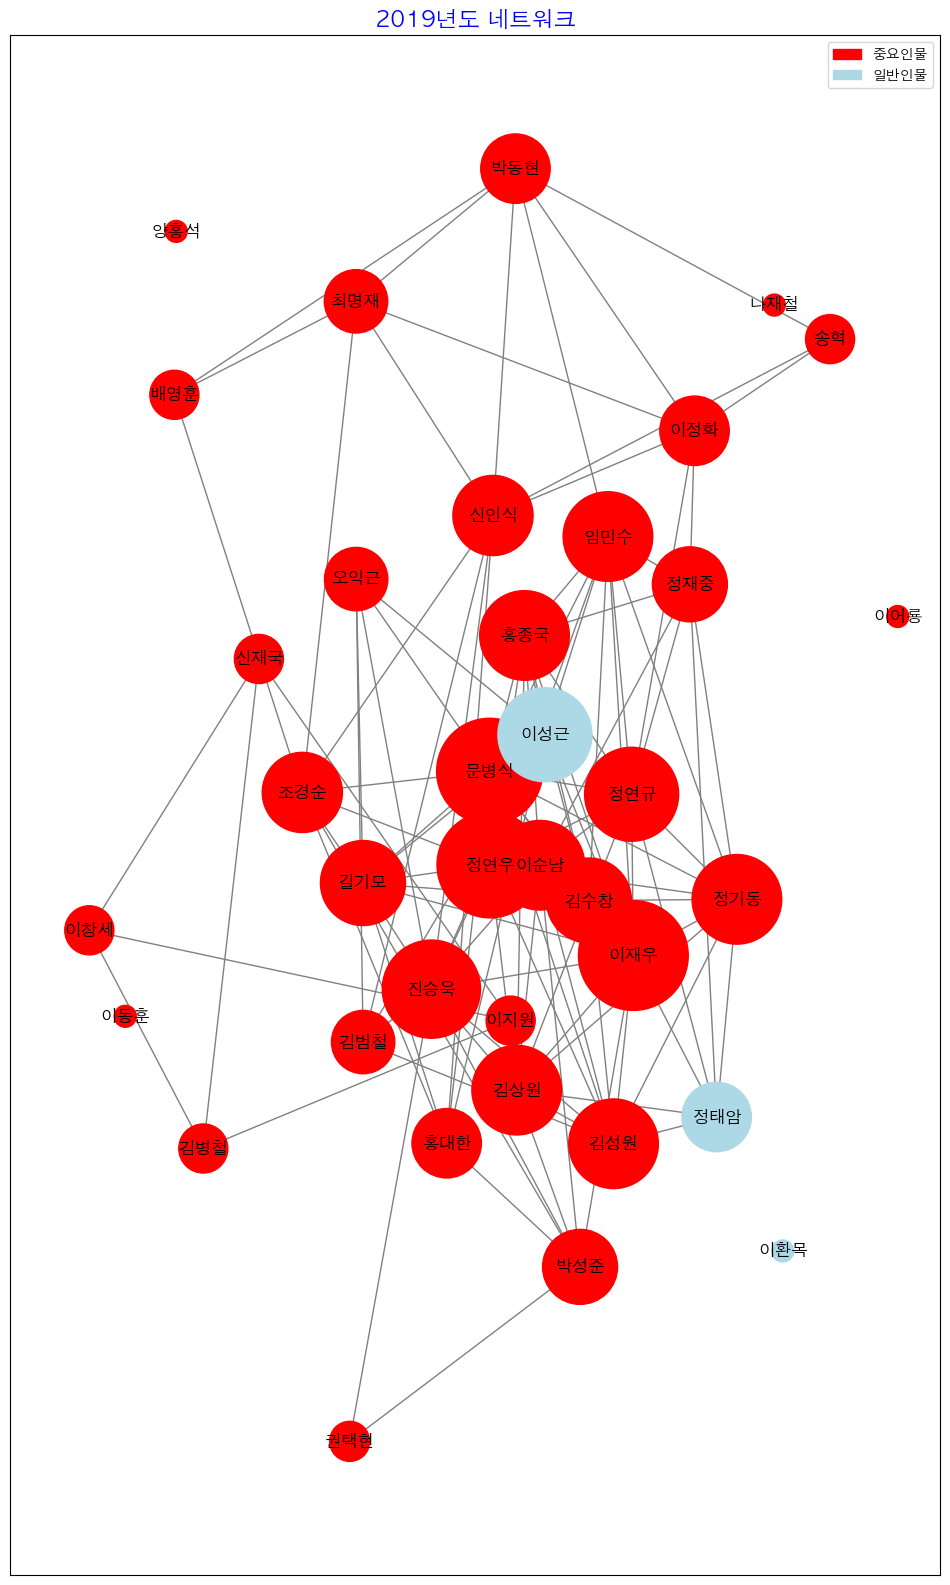

2019년도 네트워크 점수 계산

중요인물 연결 수
이재우 13
정연우 13
문병식 13
진승욱 11
이성근 11
정연규 10
이순남 10
홍종국 9
정기동 9
김성원 9
임민수 9
김상원 9
조경순 8
김수창 8
길기모 8
신인식 8
박성준 7
박동현 6
정태암 6
정재중 6
이정화 6
최명재 5
홍대한 5
김범철 4
오익근 4
신재국 3
배영훈 3
김병철 3
이지원 3
이창세 3
송혁 3
권택현 2
이환목 0
이동훈 0
양홍석 0
이어룡 0
나재철 0

Degree Centrality:
이재우 0.41666666666666663
정연우 0.38888888888888884
문병식 0.38888888888888884
진승욱 0.3333333333333333
정연규 0.3055555555555555
이성근 0.3055555555555555
홍종국 0.2777777777777778
정기동 0.2777777777777778
김성원 0.2777777777777778
이순남 0.2777777777777778
임민수 0.2777777777777778
김상원 0.2777777777777778
김수창 0.25
길기모 0.25
조경순 0.2222222222222222
신인식 0.2222222222222222
정재중 0.19444444444444442
박성준 0.19444444444444442
박동현 0.16666666666666666
정태암 0.16666666666666666
홍대한 0.16666666666666666
이정화 0.16666666666666666
최명재 0.1388888888888889
김범철 0.1388888888888889
오익근 0.1388888888888889
신재국 0.08333333333333333
배영훈 0.08333333333333333
김병철 0.08333333333333333
이지원 0.08333333333333333
이창세 0.08333333333333333
송혁 0.08333333333333333
권택현 0.05555555555555555


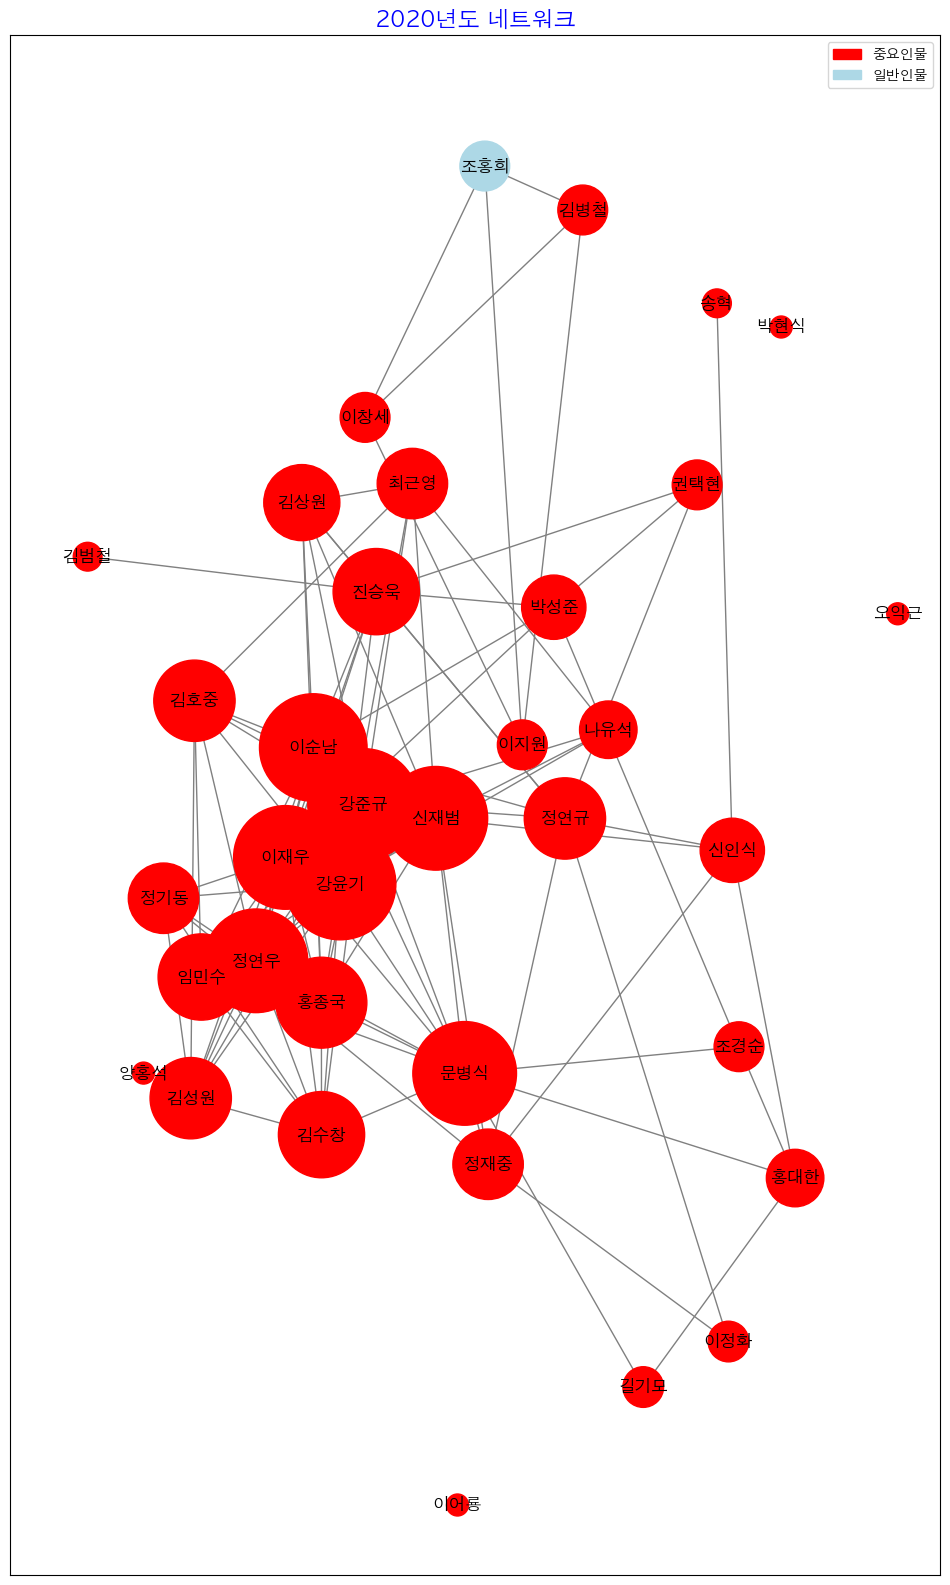

2020년도 네트워크 점수 계산

중요인물 연결 수
강윤기 15
강준규 15
이순남 14
이재우 13
정연우 13
신재범 13
문병식 13
홍종국 10
진승욱 9
임민수 9
김수창 9
김성원 8
정연규 8
김호중 8
김상원 7
정재중 6
정기동 6
최근영 6
신인식 5
박성준 5
나유석 4
홍대한 4
조경순 3
권택현 3
조홍희 3
김병철 2
이정화 2
길기모 2
이창세 2
이지원 2
송혁 1
김범철 1
오익근 0
박현식 0
이어룡 0
양홍석 0

Degree Centrality:
강윤기 0.42857142857142855
강준규 0.42857142857142855
이순남 0.39999999999999997
이재우 0.37142857142857144
정연우 0.37142857142857144
신재범 0.37142857142857144
문병식 0.37142857142857144
홍종국 0.2857142857142857
진승욱 0.2571428571428571
임민수 0.2571428571428571
김수창 0.2571428571428571
김성원 0.22857142857142856
정연규 0.22857142857142856
김호중 0.22857142857142856
김상원 0.19999999999999998
정재중 0.17142857142857143
정기동 0.17142857142857143
최근영 0.17142857142857143
신인식 0.14285714285714285
박성준 0.14285714285714285
나유석 0.11428571428571428
홍대한 0.11428571428571428
김병철 0.08571428571428572
조경순 0.08571428571428572
권택현 0.08571428571428572
이창세 0.08571428571428572
이지원 0.08571428571428572
조홍희 0.08571428571428572
이정화 0.05714285714285714
길기모 0.05714285714285714
송혁 0.0285714

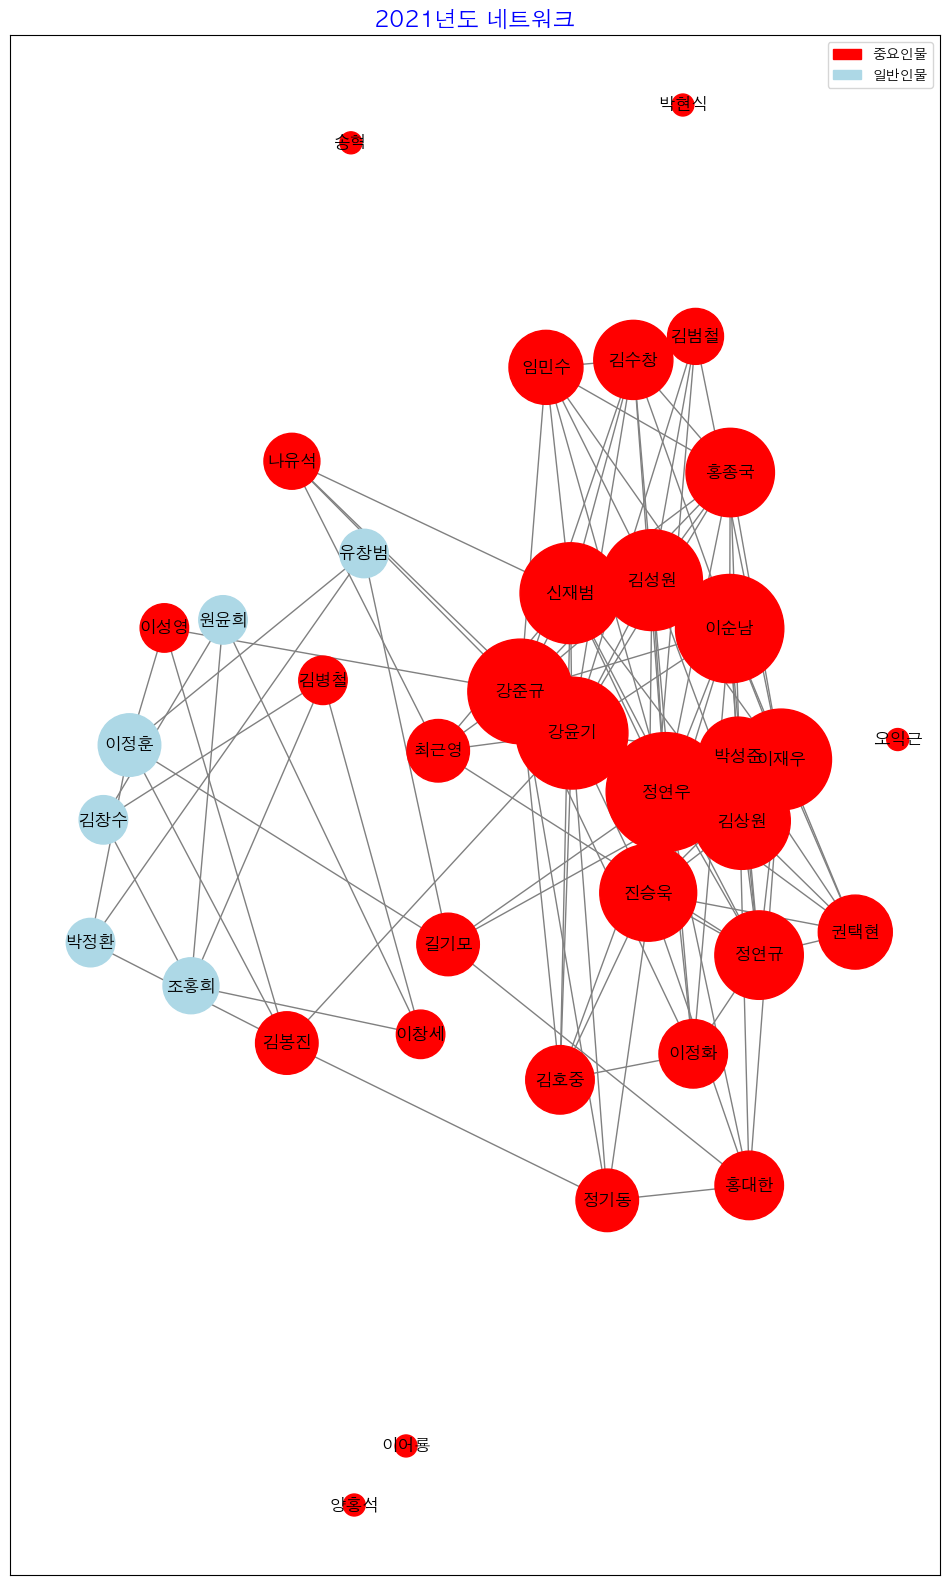

2021년도 네트워크 점수 계산

중요인물 연결 수
정연우 18
강윤기 16
이순남 15
강준규 14
김성원 13
신재범 13
이재우 13
진승욱 12
김상원 12
정연규 10
홍종국 10
박성준 8
김수창 8
임민수 7
권택현 7
이정화 6
홍대한 6
김호중 6
정기동 5
최근영 5
김범철 4
나유석 4
이정훈 3
김봉진 3
길기모 3
이성영 2
조홍희 2
김병철 1
원윤희 1
박정환 1
이창세 1
유창범 1
김창수 1
이어룡 0
양홍석 0
박현식 0
오익근 0
송혁 0

Degree Centrality:
정연우 0.4864864864864865
강윤기 0.43243243243243246
이순남 0.40540540540540543
강준규 0.3783783783783784
김성원 0.35135135135135137
신재범 0.35135135135135137
이재우 0.35135135135135137
진승욱 0.32432432432432434
김상원 0.32432432432432434
정연규 0.2702702702702703
홍종국 0.2702702702702703
박성준 0.21621621621621623
김수창 0.21621621621621623
임민수 0.1891891891891892
권택현 0.1891891891891892
이정화 0.16216216216216217
홍대한 0.16216216216216217
김호중 0.16216216216216217
이정훈 0.13513513513513514
정기동 0.13513513513513514
김봉진 0.13513513513513514
최근영 0.13513513513513514
길기모 0.13513513513513514
김범철 0.10810810810810811
조홍희 0.10810810810810811
나유석 0.10810810810810811
김병철 0.08108108108108109
이성영 0.08108108108108109
원윤희 0.08108108108108109
박정환 0.08108108108108109

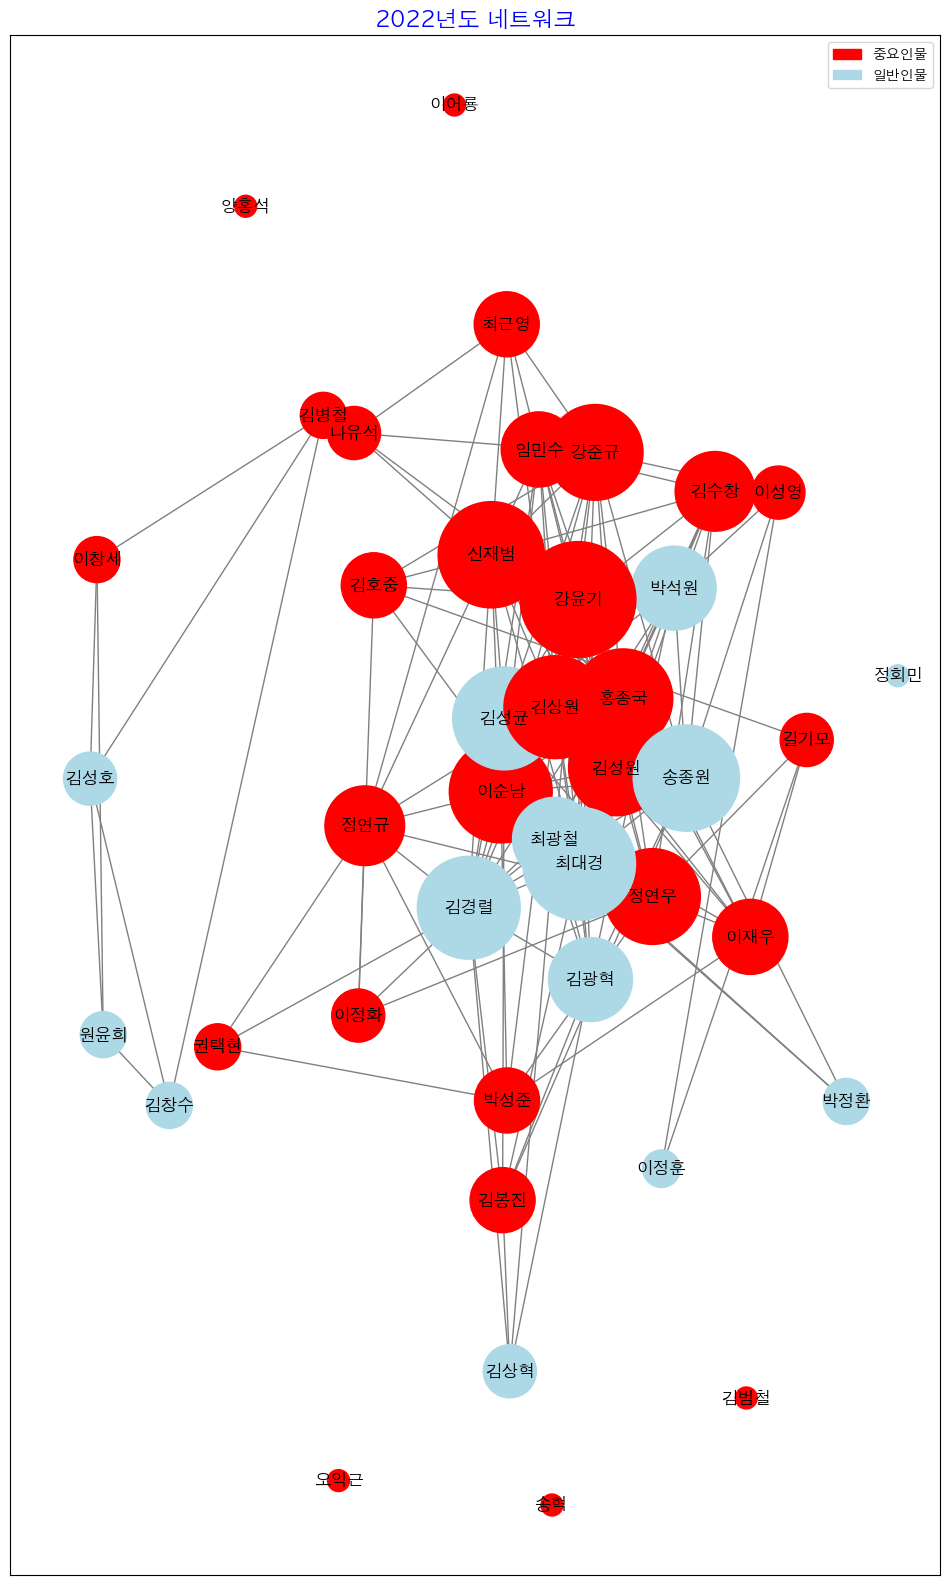

2022년도 네트워크 점수 계산

중요인물 연결 수
강윤기 12
신재범 12
이순남 11
정연우 11
김성원 11
김상원 11
최대경 11
강준규 10
홍종국 10
김성균 9
송종원 9
이재우 8
정연규 8
김경렬 8
김수창 6
임민수 6
박성준 6
최근영 5
김호중 5
이정화 4
박석원 4
나유석 4
길기모 3
김광혁 3
최광철 2
김성호 2
권택현 2
이정훈 2
김병철 1
이성영 1
김상혁 1
이창세 1
김창수 1
원윤희 1
박정환 0
송혁 0
김봉진 0
정회민 0
오익근 0
이어룡 0
양홍석 0
김범철 0

Degree Centrality:
강윤기 0.4634146341463415
최대경 0.43902439024390244
신재범 0.3902439024390244
송종원 0.3902439024390244
이순남 0.36585365853658536
김성균 0.36585365853658536
김상원 0.36585365853658536
김경렬 0.36585365853658536
홍종국 0.34146341463414637
강준규 0.3170731707317073
정연우 0.3170731707317073
김성원 0.3170731707317073
최광철 0.24390243902439024
박석원 0.24390243902439024
김광혁 0.24390243902439024
김수창 0.21951219512195122
정연규 0.21951219512195122
이재우 0.1951219512195122
임민수 0.1951219512195122
최근영 0.14634146341463417
김봉진 0.14634146341463417
박성준 0.14634146341463417
김호중 0.14634146341463417
이정화 0.0975609756097561
길기모 0.0975609756097561
김성호 0.0975609756097561
이성영 0.0975609756097561
김상혁 0.0975609756097561
나유석 0.0975609756097561
박정환 0.073

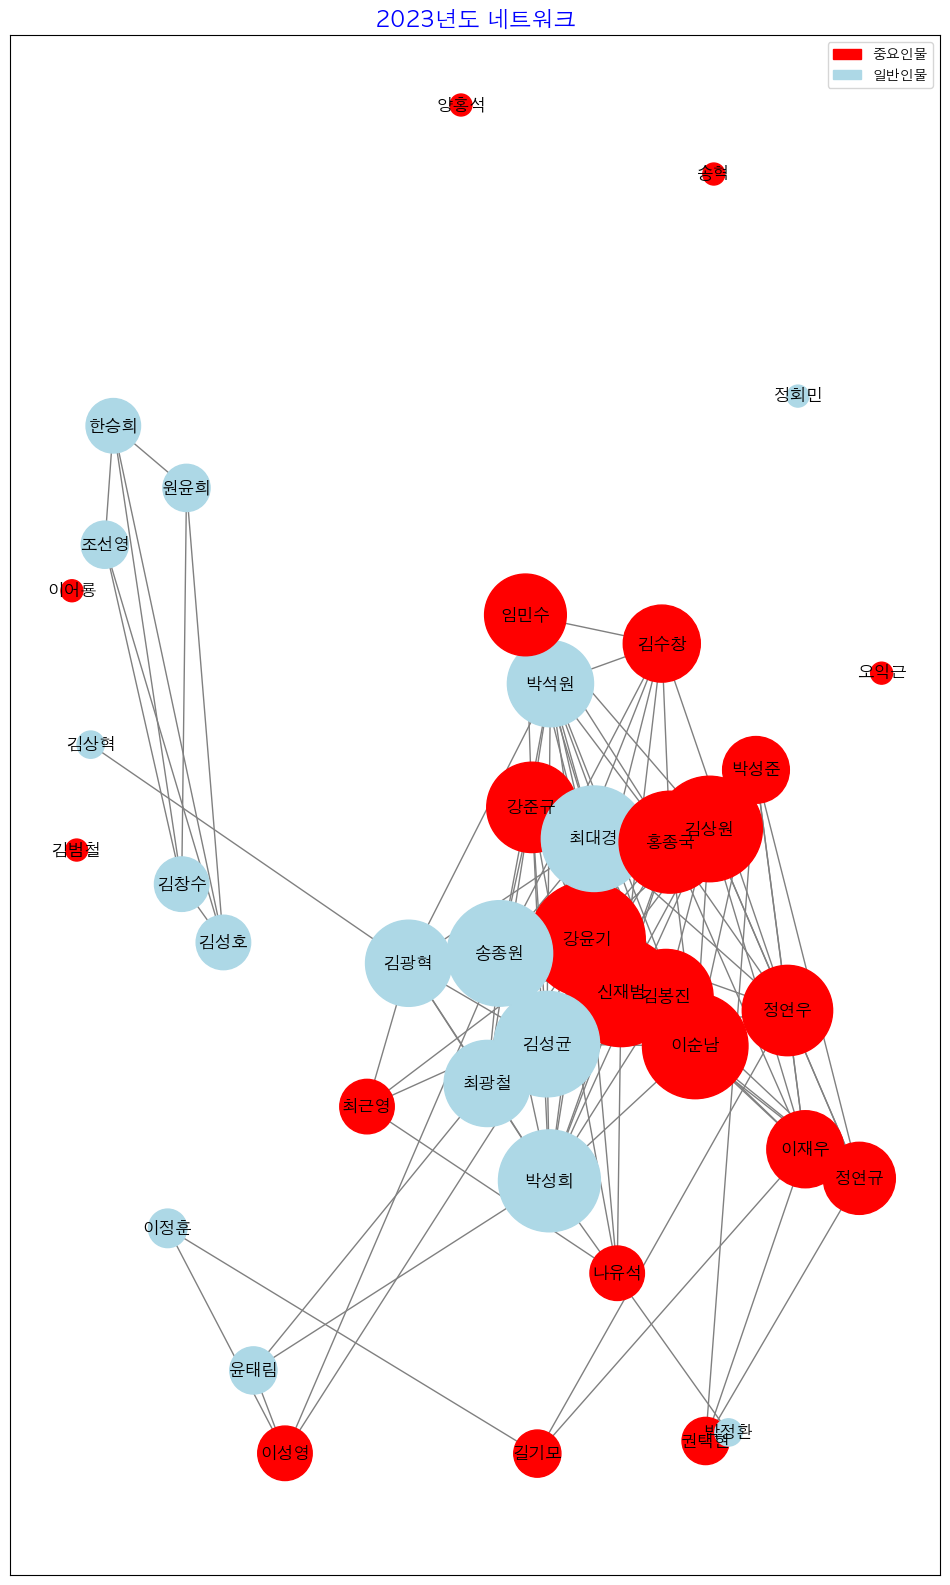

2023년도 네트워크 점수 계산

중요인물 연결 수
신재범 11
이순남 11
강윤기 11
김상원 11
송종원 9
정연우 9
최대경 9
홍종국 9
김성균 9
이재우 8
강준규 7
박성희 7
임민수 7
정연규 7
김봉진 6
박성준 6
박석원 5
김수창 5
나유석 4
최근영 3
권택현 3
최광철 3
김광혁 3
이정훈 2
길기모 2
윤태림 1
김성호 0
양홍석 0
정회민 0
박정환 0
송혁 0
김창수 0
김상혁 0
이성영 0
조선영 0
원윤희 0
오익근 0
이어룡 0
김범철 0
한승희 0

Degree Centrality:
강윤기 0.4615384615384615
신재범 0.41025641025641024
이순남 0.3846153846153846
송종원 0.3846153846153846
최대경 0.3846153846153846
김상원 0.3846153846153846
김성균 0.3846153846153846
박성희 0.358974358974359
홍종국 0.358974358974359
김봉진 0.3076923076923077
강준규 0.28205128205128205
정연우 0.28205128205128205
박석원 0.2564102564102564
최광철 0.2564102564102564
김광혁 0.2564102564102564
임민수 0.23076923076923075
이재우 0.20512820512820512
김수창 0.20512820512820512
정연규 0.1794871794871795
박성준 0.15384615384615385
김성호 0.10256410256410256
최근영 0.10256410256410256
김창수 0.10256410256410256
이성영 0.10256410256410256
나유석 0.10256410256410256
한승희 0.10256410256410256
권택현 0.07692307692307693
조선영 0.07692307692307693
원윤희 0.07692307692307693
윤태림 0.07692307692307693
길기모

In [37]:
result_dict_all_year = print_network(matrixs)

### 가중합 선정

In [38]:
#weights 값 임의로 설정
top = {}
bottom = {}
def weighted_average_values(result_dict, weights = [3.5, 2.5, 1.5, 1.5, 1], rank = 5):
    # 각 키에 해당하는 값들을 가중 평균하여 하나의 값으로 계산
    weighted_values = []
    for values in result_dict.values():
        weighted_value = sum(value * weight for value, weight in zip(values, weights))
        weighted_values.append(weighted_value)
            
    weighted_dict = {}
    keys = list(result_dict.keys())
    for i, key in enumerate(keys):
        weighted_dict[key] = weighted_values[i]

    sorted_items = sorted(weighted_dict.items(), key=lambda x: x[1], reverse=True)
    top_values = sorted_items[:rank]
    top_dict = {key: value for key, value in top_values}

    bottom_values = sorted_items[-rank:]
    bottom_dict = {key: value for key, value in bottom_values}

    for key in top_dict:
        top_dict[key] *= 100

    for key in bottom_dict:
        bottom_dict[key] *= 100
    
    return top_dict, bottom_dict


weights = [3.5, 2.5, 1.5, 1.5, 1]
for year in YEAR_LIST:
    print("-----------------------",year,"--------------------------")
       # 속성별 가중치 값
    top_dict, bottom_dict = weighted_average_values(result_dict_all_year[year], weights)  
    print(top_dict)
    print(bottom_dict)
    top[year] = top_dict
    bottom[year] = bottom_dict

----------------------- 2014 --------------------------
{'이현식': 995.251898437361, '장우철': 889.7138205917258, '장광수': 854.3321461255226, '신인식': 800.3946840293901, '김송규': 784.388252254258}
{'김경찬': 0.0, '나재철': 0.0, '양홍석': 0.0, '이동훈': 0.0, '이어룡': 0.0}
----------------------- 2015 --------------------------
{'조경순': 1000.0, '장광수': 864.1978734219588, '이현식': 822.525596140169, '장우철': 773.8674106241707, '김송규': 747.5802719741916}
{'이인형': 108.51587124521839, '나재철': 0.0, '양홍석': 0.0, '이동훈': 0.0, '이어룡': 0.0}
----------------------- 2016 --------------------------
{'김경식': 1000.0, '김범철': 719.9806883677303, '홍대한': 696.7559242969683, '조경순': 680.0360637522854, '장우철': 658.082417352889}
{'이동훈': 140.7014071142738, '이환목': 134.12167341110137, '나재철': 0.0, '양홍석': 0.0, '이어룡': 0.0}
----------------------- 2017 --------------------------
{'김범철': 920.7877142066485, '김성원': 918.3290533383449, '정재중': 827.5325689491563, '신인식': 767.2667857565738, '이정화': 760.1659575855866}
{'나재철': 0.0, '양홍석': 0.0, '이동훈': 0.0, '이어룡': 0.0, '이

## 중요인물 검증

In [19]:
print(top)

{2014: {'김봉규': 879.58393340052, '김송규': 861.7643674958231, '박규상': 856.09375, '배영훈': 727.3629942399243, '장우철': 648.3935502702005}, 2015: {'조경순': 898.3852582149603, '김송규': 879.5277468595963, '장우철': 700.2277906133819, '신인식': 685.999202171405, '박규상': 683.5657050489125}, 2016: {'김경식': 896.8147860138238, '배영훈': 861.7861740981109, '김범철': 780.5874816686854, '신인식': 780.3145707560997, '김성원': 686.7184020962568}, 2017: {'박동현': 928.069498069498, '김범철': 803.6110828175455, '하창룡': 707.4927593510664, '신인식': 702.9448948603352, '이정화': 527.6755439795893}, 2018: {'이득원': 998.2142857142858, '진승욱': 948.2142857142858, '이순남': 754.2531175521741, '이문수': 653.5264894398383, '정연규': 638.8932459515939}, 2019: {'이재우': 898.3364355514192, '정연우': 898.3364355514192, '문병식': 840.0827221183, '이순남': 807.1375409157101, '홍종국': 652.3771406653883}, 2020: {'강윤기': 1000.0, '정연우': 791.1577776295256, '이재우': 722.5228751402708, '이순남': 675.7990565874578, '김상원': 556.3064775640021}, 2021: {'김성원': 909.7307835660426, '강준규': 817.9561596916885, 

In [20]:
print(bottom)

{2014: {'나재철': 0.0, '송혁': 0.0, '양홍석': 0.0, '이동훈': 0.0, '이어룡': 0.0}, 2015: {'송혁': 0.0, '양홍석': 0.0, '이동훈': 0.0, '이어룡': 0.0, '조윤남': 0.0}, 2016: {'양홍석': 0.0, '이동훈': 0.0, '이어룡': 0.0, '이환목': 0.0, '최범진': 0.0}, 2017: {'양홍석': 0.0, '이동훈': 0.0, '이어룡': 0.0, '이환목': 0.0, '정태영': 0.0}, 2018: {'이동훈': 0.0, '이어룡': 0.0, '이환목': 0.0, '정태암': 0.0, '최명재': 0.0}, 2019: {'나재철': 0.0, '양홍석': 0.0, '이동훈': 0.0, '이어룡': 0.0, '이환목': 0.0}, 2020: {'박현식': 0.0, '송혁': 0.0, '양홍석': 0.0, '오익근': 0.0, '이어룡': 0.0}, 2021: {'송혁': 0.0, '양홍석': 0.0, '오익근': 0.0, '이성영': 0.0, '이어룡': 0.0}, 2022: {'오익근': 0.0, '이성영': 0.0, '이어룡': 0.0, '이정훈': 0.0, '정회민': 0.0}, 2023: {'양홍석': 0.0, '오익근': 0.0, '윤태림': 0.0, '이어룡': 0.0, '정회민': 0.0}}


### 2014

In [21]:
top[2014]

{'김봉규': 879.58393340052,
 '김송규': 861.7643674958231,
 '박규상': 856.09375,
 '배영훈': 727.3629942399243,
 '장우철': 648.3935502702005}

In [22]:
bottom[2014]

{'나재철': 0.0, '송혁': 0.0, '양홍석': 0.0, '이동훈': 0.0, '이어룡': 0.0}

#### 상위

In [23]:
df.loc[df['이름'] == '김봉규']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위,대학교,전공,근속연수,주요경력요약
22,김봉규,2014,1964.04,미등기임원,상근,울산지점장,울산대 경영학\n대신증권 울산남지점장\n대신증권무거동지점장\n대신증권 울산지점 이사...,7673.0,2013.04.01~2014.12.31,2015.03.20,상무보,울산대,경영학,1,"{대신증권무거동지점장, 대신증권}"


In [24]:
df.loc[df['이름'] == '김송규']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위,대학교,전공,근속연수,주요경력요약
14,김송규,2014,1964.08,미등기임원,상근,인프라관리본부장,대전대 경영학(박사)\n대신증권 관재팀장\n대신증권 총무부장,12168.0,2011.04.01~2014.12.31,2015.03.20,상무,대전대,경영학,3,{대신증권}
37,김송규,2015,1964.08,미등기임원,상근,인프라관리본부장,대전대 경영학(박사)\n대신증권 관재팀장\n대신증권 총무부장,12434.0,2011.04.01~2015.12.31,2016.03.18,전무,대전대,경영학,4,{대신증권}


In [25]:
df.loc[df['이름'] == '박규상']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위,대학교,전공,근속연수,주요경력요약
12,박규상,2014,1965.01,미등기임원,상근,영업부장,연세대 경영학\n대신증권 법인영업부장\n대신증권 Wholesale1본부장\n대신증권...,8389.0,2011.04.01~2014.12.31,2015.03.20,상무보,연세대,경영학,3,{대신증권}
30,박규상,2015,1965.01,미등기임원,상근,영업부장,연세대 경영학\n대신증권 법인영업부장\n대신증권 Wholesale1본부장\n대신증권...,12021.0,2011.04.01~2015.12.31,2016.03.18,상무보,연세대,경영학,4,{대신증권}
75,박규상,2016,1965.01,미등기임원,상근,영업부장,연세대 경영학\n대신증권 법인영업부장\n대신증권 Wholesale1본부장\n대신증권...,12021.0,2011.04.01~2016.12.31,2018.03.31,상무보,연세대,경영학,5,{대신증권}
122,박규상,2017,1965.01,미등기임원,상근,영업부장,연세대 경영학\n대신증권 법인영업부장\n대신증권 Wholesale1본부장\n대신증권...,9036.0,2011.04.01~2017.12.31,2018.03.23,상무보,연세대,경영학,6,{대신증권}


In [26]:
df.loc[df['이름'] == '배영훈']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위,대학교,전공,근속연수,주요경력요약
27,배영훈,2014,1964.02,미등기임원,상근,구조화상품본부장,연세대 경영학\n대신증권 장외파생상품부장\n대신증권 파생상품영업부장\n대신증권 해외...,32519.0,2011.04.01~2014.12.31,2015.03.20,전무,연세대,경영학,3,{대신증권}
40,배영훈,2015,1964.02,미등기임원,상근,구조화상품본부장,연세대 경영학\n대신증권 장외파생상품부장\n대신증권 파생상품영업부장\n대신증권 해외...,43189.0,2011.04.01~2015.12.31,2016.03.18,전무,연세대,경영학,4,{대신증권}
95,배영훈,2016,1964.02,미등기임원,상근,Solution&Product사업단장,연세대 경영학\n대신증권 장외파생상품부장\n대신증권 해외파생상품부장\n대신증권 파생...,52540.0,2011.04.01~2016.12.31,2018.03.31,전무,연세대,경영학,5,{대신증권}
110,배영훈,2017,1964.02,미등기임원,상근,Solution&Product사업단장,연세대 경영학\n대신증권 장외파생상품부장\n대신증권 해외파생상품부장\n대신증권 파생...,52862.0,2011.04.01~2017.12.31,2018.03.23,전무,연세대,경영학,6,{대신증권}
140,배영훈,2018,1964.02,미등기임원,상근,Solution&Product사업단장,연세대 경영학\n대신증권 장외파생상품부장\n대신증권 해외파생상품부장\n대신증권 파생...,62720.0,2011.04.01~2018.12.31,2019.03.31,전무,연세대,경영학,7,{대신증권}
172,배영훈,2019,1964.02,미등기임원,상근,-,연세대 경영학\n대신증권 장외파생상품부장\n대신증권 해외파생상품부장\n대신증권 파생...,52051.0,2011.04.01~2019.12.31,2020.03.20,전무,연세대,경영학,8,{대신증권}


In [27]:
df.loc[df['이름'] == '장우철']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위,대학교,전공,근속연수,주요경력요약
29,장우철,2014,1963.05,미등기임원,상근,IB부문장,전남대 경영학\n대신증권 선릉역지점장\n대신증권 영업부장\n대신증권 금융주치의추진부...,6257.0,2011.04.01~2014.12.31,2015.03.20,상무,전남대,경영학,3,{대신증권}
41,장우철,2015,1963.05,미등기임원,상근,IB부문장,전남대 경영학\n대신증권 선릉역지점장\n대신증권 영업부장\n대신증권 금융주치의추진부...,6523.0,2011.04.01~2015.12.31,2016.03.18,상무,전남대,경영학,4,{대신증권}
74,장우철,2016,1963.05,미등기임원,상근,IB1부문장,전남대 경영학\n대신증권 영업부장\n대신증권 금융주치의추진부장\n대신증권 강북지역본...,6523.0,2011.04.01~2016.12.31,2018.03.31,전무,전남대,경영학,5,{대신증권}
115,장우철,2017,1963.05,미등기임원,상근,IB1부문장,전남대 경영학\n대신증권 영업부장\n대신증권 금융주치의추진부장\n대신증권 강북지역본...,3282.0,2011.04.01~2017.12.31,2018.03.23,전무,전남대,경영학,6,{대신증권}


#### 하위

In [28]:
df.loc[df['이름'] == '나재철']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위,대학교,전공,근속연수,주요경력요약
2,나재철,2014,1960.01,등기임원,상근,업무총괄,한국외국어대 경영학(석사)\n대신증권 강남지역본부장\n대신증권 WM추진본부장\n대신...,23301.0,2004.04.01~2014.12.31,2016.03.31,대표이사,한국외국어대,경영학,10,"{기업금융사업단장, 대신증권, 기획본부장대신증권}"
43,나재철,2015,1960.01,등기임원,상근,업무총괄,한국외국어대 경영학(석사)\n대신증권 강남지역본부장\n대신증권 WM추진본부장\n대신...,27628.0,2004.04.01~2015.12.31,2016.03.18,대표이사,한국외국어대,경영학,11,"{기획본부장대신증권인재역량센터장,, 대신증권}"
73,나재철,2016,1960.01,등기임원,상근,업무총괄,한국외국어대 경영학(석사)\n대신증권 강남지역본부장\n대신증권 WM추진본부장\n대신...,33663.0,2004.04.01~2016.12.31,2018.03.31,대표이사,한국외국어대,경영학,12,"{기획본부장대신증권인재역량센터장,, 대신증권}"
126,나재철,2017,1960.01,등기임원,상근,업무총괄,한국외국어대 경영학(석사)\n대신증권 강남지역본부장\n대신증권 WM추진본부장\n대신...,25456.0,2004.04.01~2017.12.31,2018.03.23,대표이사,한국외국어대,경영학,13,{대신증권}
153,나재철,2018,1960.01,등기임원,상근,업무총괄,한국외국어대 경영학(석사)\n대신증권 강남지역본부장\n대신증권 WM추진본부장\n대신...,36307.0,2004.04.01~2018.12.31,2020.03.31,대표이사,한국외국어대,경영학,14,{대신증권}
186,나재철,2019,1960.01,등기임원,상근,업무총괄,한국외국어대경영학(석사)\n대신증권 강남지역본부장\n대신증권 WM추진본부장\n대신증...,49666.0,2004.04.01~2019.12.31,2020.03.20,대표이사,한국외국어대,경영학,15,{대신증권}


In [29]:
df.loc[df['이름'] == '송혁']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위,대학교,전공,근속연수,주요경력요약
4,송혁,2014,1964.04,미등기임원,상근,비서/브랜드담당,전북대 회계학\n대신증권 인수공모2부\n대신증권 비서실장,10391.0,2010.04.01~2014.12.31,2015.03.20,전무,전북대,회계학,4,{대신증권}
52,송혁,2015,1964.04,미등기임원,상근,비서/브랜드담당,전북대 회계학\n대신증권 인수공모2부\n대신증권 비서실장,10657.0,2010.04.01~2015.12.31,2016.03.18,전무,전북대,회계학,5,{대신증권}
62,송혁,2016,1964.04,미등기임원,상근,비서/브랜드담당,전북대 회계학\n대신증권 인수공모2부\n대신증권 비서실장,10657.0,2010.04.01~2016.12.31,2018.03.31,전무,전북대,회계학,6,{대신증권}
106,송혁,2017,1964.04,미등기임원,상근,비서/브랜드본부,전북대 회계학\n대신증권 인수공모2부\n대신증권 비서실장,0.0,2010.04.01~2017.12.31,2018.03.23,전무,전북대,회계학,7,{대신증권}
156,송혁,2018,1964.04,미등기임원,상근,비서/브랜드본부,전북대 회계학\n대신증권 인수공모2부\n대신증권 비서실장,282.0,2010.04.01~2018.12.31,2019.03.31,전무,전북대,회계학,8,{대신증권}
191,송혁,2019,1964.04,미등기임원,상근,비서/브랜드본부,전북대 회계학\n대신증권 인수공모2부\n대신증권 비서실장,1195.0,2010.04.01~2019.12.31,2021.03.31,전무,전북대,회계학,9,{대신증권}
204,송혁,2020,1964.04,미등기임원,상근,WM사업단장,전북대 회계학\n대신증권 인수공모2부\n대신증권 비서실장\n대신증권 비서/브랜드본부장,2869.0,2010.04.01~2020.12.31,2022.03.31,부사장,전북대,회계학,10,{대신증권}
271,송혁,2021,1964.04,미등기,상근,리테일총괄,전북대 회계학\n대신증권 인수공모2부\n대신증권 비서실장\n대신증권 비서/브랜드본부...,9239.0,2010.04.01~2021.12.31,2023.03.31,부사장,전북대,회계학,11,{대신증권}
282,송혁,2022,1964.04,미등기,상근,리테일총괄,전북대 회계학\n대신증권 비서실장\n대신증권 비서/브랜드본부장\n대신증권 WM사업단...,29146.0,2010.04.01~2022.12.31,2024.3.31,부사장,전북대,회계학,12,{대신증권}
325,송혁,2023,1964.04,사내이사,상근,리테일총괄,전북대 회계학\n대신증권 비서실장\n대신증권 비서/브랜드본부장\n대신증권 WM사업단...,32531.0,2010.04.01~2023.03.31,2025.03.31,부사장,전북대,회계학,13,{대신증권}


In [30]:
df.loc[df['이름'] == '양홍석']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위,대학교,전공,근속연수,주요경력요약
21,양홍석,2014,1981.04,등기임원,상근,"업무총괄(IB사업단, 고객자산본부 제외)",서울대 경영학\n대신투자신탁운용 상무이사\n대신증권 전무\n대신증권 부사장,3383966.0,2007.10.01~2014.12.31,2016.03.31,사장,서울대,경영학,7,"{대신투자신탁운용, 대신증권}"
36,양홍석,2015,1981.04,등기임원,상근,"업무총괄(IB사업단, 고객자산본부 제외)",서울대 경영학\n대신투자신탁운용상무이사\n대신증권 전무\n대신증권 부사장,3512510.0,2007.10.01~2015.12.31,2016.03.18,사장,서울대,경영학,8,"{대신증권, 대신투자신탁운용상무이사}"
87,양홍석,2016,1981.04,등기임원,상근,"업무총괄(IB사업단,고객자산본부 제외)",서울대 경영학\n대신투자신탁운용 상무이사\n대신증권 전무\n대신증권 부사장,3562689.0,2007.10.01~2016.12.31,2018.03.31,사장,서울대,경영학,9,"{대신투자신탁운용, 대신증권}"
127,양홍석,2017,1981.04,등기임원,상근,"업무총괄(IB사업단,고객자산본부 제외)",서울대 경영학\n대신투자신탁운용 상무이사\n대신증권 전무\n대신증권 부사장,3575722.0,2007.10.01~2017.12.31,2018.03.23,사장,서울대,경영학,10,"{대신투자신탁운용, 대신증권}"
150,양홍석,2018,1981.04,등기임원,상근,"업무총괄 (IB사업단,고객자산본부 제외)",서울대 경영학\n대신투자신탁운용 상무이사\n대신증권 전무\n대신증권 부사장,3814174.0,2007.10.01~2018.12.31,2020.03.31,사장,서울대,경영학,11,"{대신투자신탁운용, 대신증권}"
183,양홍석,2019,1981.04,등기임원,상근,"업무총괄(IB사업단, 고객자산본부, 경영지원본부, 정보보호부문, 준법지원부문, 감사...",서울대 경영학\n대신투자신탁운용 상무이사\n대신증권 전무\n대신증권 부사장,3976804.0,2007.10.01~2019.12.31,2020.03.20,사장,서울대,경영학,12,"{대신투자신탁운용, 대신증권}"
230,양홍석,2020,1981.04,등기임원,상근,-,서울대 경영학\n대신투자신탁운용 상무이사\n대신증권 전무\n대신증권 부사장,4610498.0,2007.10.01~2020.12.31,2022.03.31,사장,서울대,경영학,13,"{대신투자신탁운용, 대신증권}"
235,양홍석,2021,1981.04,사내이사,상근,-,서울대 경영학\n대신투자신탁운용 상무이사\n대신증권 전무\n대신증권 부사장\n대신증...,4985667.0,2007.10.01~2021.12.31,2022.03.31,부회장,서울대,경영학,14,"{대신투자신탁운용, 대신증권}"
299,양홍석,2022,1981.04,사내이사,상근,-,서울대 경영학\n대신투자신탁운용 상무이사\n대신증권 전무\n대신증권 부사장\n대신증...,5175034.0,2007.10.01~2022.12.31,2024.3.31,부회장,서울대,경영학,15,"{대신투자신탁운용, 대신증권}"
316,양홍석,2023,1981.04,사내이사,상근,-,서울대 경영학\n대신투자신탁운용 상무이사\n대신증권 전무\n대신증권 부사장\n대신증...,5175034.0,2007.10.01~2023.03.31,2024.03.31,부회장,서울대,경영학,16,"{대신투자신탁운용, 대신증권}"


In [31]:
df.loc[df['이름'] == '이동훈']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위,대학교,전공,근속연수,주요경력요약
6,이동훈,2014,1972.03,미등기임원,상근,Trading Center장,조지아공대 항공우주학(박사)\n대신증권 파생상품운용부 부장\n대신증권 자산운용본부 ...,66237.0,2014.01.01~2014.12.31,2015.03.20,상무,조지아공대,항공우주학,0,{대신증권}
49,이동훈,2015,1972.03,미등기임원,상근,Trading Center장,조지아공대 항공우주학(박사)\n대신증권파생상품운용부장\n대신증권자산운용본부 이사대우본부장,129006.0,2014.01.01~2015.12.31,2016.03.18,상무,조지아공대,항공우주학,1,"{대신증권파생상품운용부장, 대신증권자산운용본부}"
82,이동훈,2016,1972.03,미등기임원,상근,Product부문장,조지아공대 항공우주학(박사)\n대신증권파생상품운용부장\n대신증권자산운용본부 이사대우...,193868.0,2014.01.01~2016.12.31,2018.03.31,상무,조지아공대,항공우주학,2,"{대신증권파생상품운용부장, 대신증권자산운용본부, 대신증권}"
114,이동훈,2017,1972.03,미등기임원,상근,Product부문장,조지아공대 항공우주학(박사)\n대신증권파생상품운용부장\n대신증권자산운용본부 이사대우...,222772.0,2014.01.01~2017.12.31,2018.03.23,상무,조지아공대,항공우주학,3,"{대신증권파생상품운용부장, 대신증권자산운용본부, 대신증권}"
152,이동훈,2018,1972.03,미등기임원,상근,경영기획본부장,조지아공대 항공우주학(박사)\n대신증권파생상품운용부장\n대신증권자산운용본부 이사대우...,233370.0,2014.01.01~2018.12.31,2019.03.31,상무,조지아공대,항공우주학,4,"{대신증권파생상품운용부장, 대신증권자산운용본부, 대신증권}"
176,이동훈,2019,1972.03,미등기임원,상근,-,조지아공대 항공우주학(박사)\n대신증권파생상품운용부장\n대신증권자산운용본부 이사대우...,234218.0,2014.01.01~2019.12.31,2020.03.20,전무,조지아공대,항공우주학,5,"{대신증권파생상품운용부장, 대신증권자산운용본부, 대신증권}"


In [32]:
df.loc[df['이름'] == '이어룡']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위,대학교,전공,근속연수,주요경력요약
20,이어룡,2014,1953.09,등기임원,상근,-,상명여자사범대,759552.0,2004.09.24~2014.12.31,2015.03.20,회장,상명여자사범대,교육학,10,{대신증권}
46,이어룡,2015,1953.09,등기임원,상근,-,상명여자사범대,810333.0,2004.09.24~2015.12.31,2017.03.31,회장,상명여자사범대,교육학,11,{대신증권}
70,이어룡,2016,1953.09,등기임원,상근,-,상명여자사범대,863672.0,2004.09.24~2016.12.31,2017.03.24,회장,상명여자사범대,교육학,12,{대신증권}
96,이어룡,2017,1953.09,등기임원,상근,-,상명여자사범대,921029.0,2004.09.24~2017.12.31,2019.03.31,회장,상명여자사범대,교육학,13,{대신증권}
139,이어룡,2018,1953.09,등기임원,상근,-,상명여자사범대,989350.0,2004.09.24~2018.12.31,2019.03.31,회장,상명여자사범대,교육학,14,{대신증권}
184,이어룡,2019,1953.09,등기임원,상근,-,상명여자사범대,1047899.0,2004.09.24~2019.12.31,2021.03.31,회장,상명여자사범대,교육학,15,{대신증권}
227,이어룡,2020,1953.09,등기임원,상근,-,상명여자사범대,1105633.0,2004.09.24~2020.12.31,2021.03.19,회장,상명여자사범대,교육학,16,{대신증권}
234,이어룡,2021,1953.09,사내이사,상근,-,상명여자사범대,1198371.0,2004.09.24~2021.12.31,2023.03.31,회장,상명여자사범대,교육학,17,{대신증권}
298,이어룡,2022,1953.09,사내이사,상근,-,상명여자사범대,1271697.0,2004.09.24~2022.12.31,2023.3.31,회장,상명여자사범대,교육학,18,{대신증권}
348,이어룡,2023,1953.09,미등기,상근,-,상명여자사범대,1271697.0,2004.09.24~2023.03.31,2024.03.31,회장,상명여자사범대,교육학,19,{대신증권}


### 2015

In [7]:
df.loc[df['이름'] == '김송규']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
14,김송규,2014,1964.08,미등기임원,상근,인프라관리본부장,대전대 경영학(박사)\n대신증권 관재팀장\n대신증권 총무부장,12168.0,2011.04.01~2014.12.31,2015.03.20,상무
37,김송규,2015,1964.08,미등기임원,상근,인프라관리본부장,대전대 경영학(박사)\n대신증권 관재팀장\n대신증권 총무부장,12434.0,2011.04.01~2015.12.31,2016.03.18,전무


In [8]:
df.loc[df['이름'] == '조경순']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
23,조경순,2014,1964.01,미등기임원,상근,기획본부장,연세대 경영대학원(석사)\n대신증권 홍보실 이사대우실장\n대신증권 브랜드전략실 이사...,11526.0,2014.01.01~2014.12.31,2015.03.20,상무
58,조경순,2015,1964.01,미등기임원,상근,기획본부장,연세대 경제학(석사)\n대신증권 홍보실 이사대우실장\n대신증권 브랜드전략실 이사대우실장,11646.0,2014.01.01~2015.12.31,2016.03.18,상무
90,조경순,2016,1964.01,미등기임원,상근,고객자산본부장 / 홍보담당,연세대 경제학(석사)\n대신증권 홍보실 이사대우실장\n대신증권 브랜드전략실 이사대우...,11636.0,2014.01.01~2016.12.31,2018.03.31,상무
102,조경순,2017,1964.01,미등기임원,상근,고객자산본부장 / 홍보담당,연세대 경제학(석사)\n대신증권 홍보실 이사대우실장\n대신증권 브랜드전략실 이사대우...,2770.0,2014.01.01~2017.12.31,2018.03.23,상무
143,조경순,2018,1964.01,미등기임원,상근,고객자산본부장/ 홍보담당,연세대 경제학(석사)\n대신증권 홍보실 이사대우실장\n대신증권 브랜드전략실 이사대우...,3013.0,2014.01.01~2018.12.31,2019.03.31,전무
171,조경순,2019,1964.01,미등기임원,상근,고객자산본부장/ 홍보부문장,연세대 경제학(석사)\n대신증권 홍보실 이사대우실장\n대신증권 브랜드전략실 이사대우...,3792.0,2014.01.01~2019.12.31,2021.03.31,전무
207,조경순,2020,1964.01,미등기임원,상근,대외협력담당,연세대 경제학(석사)\n대신증권 홍보실 이사대우실장\n대신증권 브랜드전략실 이사대우...,12749.0,2014.01.01~2020.12.31,2021.03.19,전무


### 2016

In [9]:
df.loc[df['이름'] == '신인식']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
10,신인식,2014,1962.01,미등기임원,상근,동부지역본부장,성균관대 회계학\n대신증권 무역센터지점장\n대신증권 분당지점장\n대신증권 강남선릉센...,8409.0,2013.04.01~2014.12.31,2015.03.20,상무
51,신인식,2015,1962.01,미등기임원,상근,동부지역본부장,성균관대 회계학\n대신증권 무역센터지점장\n대신증권 분당지점장\n대신증권 강남선릉센...,8520.0,2013.04.01~2015.12.31,2016.03.18,상무
71,신인식,2016,1962.01,미등기임원,상근,금융주치의사업단장,성균관대 회계학\n대신증권 무역센터지점장\n대신증권 강남선릉센터 이사대우센터장\n대...,8520.0,2013.04.01~2016.12.31,2018.03.31,전무
117,신인식,2017,1962.01,미등기임원,상근,금융주치의사업단장,성균관대 회계학\n대신증권 무역센터지점장\n대신증권 강남선릉센터 이사대우센터장\n대...,0.0,2013.04.01~2017.12.31,2018.03.23,전무
155,신인식,2018,1962.01,미등기임원,상근,WM사업단장,성균관대 회계학\n대신증권 무역센터지점장\n대신증권 강남선릉센터 이사대우센터장\n대...,276.0,2013.04.01~2018.12.31,2019.03.31,전무
193,신인식,2019,1962.01,미등기임원,상근,WM사업단장,성균관대 회계학\n대신증권 무역센터지점장\n대신증권 강남선릉센터 이사대우센터장\n대...,1136.0,2013.04.01~2019.12.31,2021.03.31,전무
206,신인식,2020,1962.01,미등기임원,상근,-,성균관대 회계학\n대신증권 무역센터지점장\n대신증권 강남선릉센터 이사대우센터장\n대...,2673.0,2013.04.01~2020.12.31,2021.03.19,전무


In [10]:
df.loc[df['이름'] == '김경식']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
15,김경식,2014,1959.12,등기임원,상근,상근감사위원,연세대 경제학(석사)\nSBC WARBURG DILLON READ(현UBS증권) 법...,0.0,2011.05.27~2014.12.31,2015.03.20,감사위원
39,김경식,2015,1959.12,미등기임원,상근,감사담당,연세대 경제학(석사)\nSBC WARBURG DILLON READ(현UBS증권) 법...,0.0,2015.03.20~2015.12.31,2016.03.18,전무
79,김경식,2016,1959.12,미등기임원,상근,-,연세대 경제학(석사)\nSBC WARBURG DILLON READ(현UBS증권) 법...,0.0,2015.03.20~2016.12.31,2017.03.24,전무


In [11]:
df.loc[df['이름'] == '배영훈']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
27,배영훈,2014,1964.02,미등기임원,상근,구조화상품본부장,연세대 경영학\n대신증권 장외파생상품부장\n대신증권 파생상품영업부장\n대신증권 해외...,32519.0,2011.04.01~2014.12.31,2015.03.20,전무
40,배영훈,2015,1964.02,미등기임원,상근,구조화상품본부장,연세대 경영학\n대신증권 장외파생상품부장\n대신증권 파생상품영업부장\n대신증권 해외...,43189.0,2011.04.01~2015.12.31,2016.03.18,전무
95,배영훈,2016,1964.02,미등기임원,상근,Solution&Product사업단장,연세대 경영학\n대신증권 장외파생상품부장\n대신증권 해외파생상품부장\n대신증권 파생...,52540.0,2011.04.01~2016.12.31,2018.03.31,전무
110,배영훈,2017,1964.02,미등기임원,상근,Solution&Product사업단장,연세대 경영학\n대신증권 장외파생상품부장\n대신증권 해외파생상품부장\n대신증권 파생...,52862.0,2011.04.01~2017.12.31,2018.03.23,전무
140,배영훈,2018,1964.02,미등기임원,상근,Solution&Product사업단장,연세대 경영학\n대신증권 장외파생상품부장\n대신증권 해외파생상품부장\n대신증권 파생...,62720.0,2011.04.01~2018.12.31,2019.03.31,전무
172,배영훈,2019,1964.02,미등기임원,상근,-,연세대 경영학\n대신증권 장외파생상품부장\n대신증권 해외파생상품부장\n대신증권 파생...,52051.0,2011.04.01~2019.12.31,2020.03.20,전무


### 2017

In [12]:
df.loc[df['이름'] == '박동현']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
7,박동현,2014,1963.06,미등기임원,상근,서부지역본부장,고려대 법학\n대신증권 화정동지점장\n대신증권 상무지점장\n대신증권 무등지점 이사대...,6736.0,2013.04.01~2014.12.31,2015.03.20,상무
47,박동현,2015,1963.06,미등기임원,상근,서부지역본부장,고려대 법학\n대신증권 화정동지점장\n대신증권 상무지점장\n대신증권 무등지점 이사대...,6846.0,2013.04.01~2015.12.31,2016.03.18,상무
68,박동현,2016,1963.06,미등기임원,상근,서부지역본부장,고려대 법학\n대신증권 화정동지점장\n대신증권 상무지점장\n대신증권 무등지점 이사대...,6846.0,2013.04.01~2016.12.31,2018.03.31,전무
97,박동현,2017,1963.06,미등기임원,상근,서부지역본부장,고려대 법학\n대신증권 화정동지점장\n대신증권 상무지점장\n대신증권 무등지점 이사대...,0.0,2013.04.01~2017.12.31,2018.03.23,전무
141,박동현,2018,1963.06,미등기임원,상근,강남지역본부장,고려대 법학\n대신증권 화정동지점장\n대신증권 상무지점장\n대신증권 무등지점 이사대...,243.0,2013.04.01~2018.12.31,2019.03.31,전무
169,박동현,2019,1963.06,미등기임원,상근,-,고려대 법학\n대신증권 화정동지점장\n대신증권 상무지점장\n대신증권 무등지점 이사대...,992.0,2013.04.01~2019.12.31,2020.03.20,전무


In [13]:
df.loc[df['이름'] == '김범철']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
80,김범철,2016,1963.08,미등기임원,상근,기획본부장 / 투자금융담당,고려대 경영학\n대신증권 기획실장\n대신자산운용 전무\n대신증권 미래전략담당\n대신...,6982.0,2016.01.01~2016.12.31,2018.03.31,전무
105,김범철,2017,1963.08,미등기임원,상근,기획본부장 / 투자금융담당,고려대 경영학\n대신증권 기획실장\n대신자산운용 전무\n대신증권 미래전략담당\n대신...,0.0,2016.01.01~2017.12.31,2018.03.23,전무
158,김범철,2018,1963.08,미등기임원,상근,경영전략총괄,고려대 경영학\n대신증권 기획실장\n대신자산운용 전무\n대신증권 미래전략담당\n대신...,280.0,2016.01.01~2018.12.31,2019.03.31,전무
182,김범철,2019,1963.08,미등기임원,상근,경영전략총괄,고려대 경영학\n대신증권 기획실장\n대신자산운용 전무\n대신증권 미래전략담당\n대신...,1173.0,2016.01.01~2019.12.31,2021.03.31,부사장
212,김범철,2020,1963.08,미등기임원,상근,경영전략총괄,고려대 경영학\n대신증권 기획실장\n대신자산운용 전무\n대신증권 미래전략담당\n대신...,3145.0,2016.01.01~2020.12.31,2022.03.31,부사장
237,김범철,2021,1963.08,미등기,상근,경영전략총괄,고려대 경영학\n대신증권 기획실장\n대신자산운용 전무\n대신증권 미래전략담당\n대신...,10649.0,2016.01.01~2021.12.31,2023.03.31,부사장
304,김범철,2022,1963.08,미등기,상근,경영전략총괄,고려대 경영학\n대신증권 기획실장\n대신자산운용 전무\n대신증권 미래전략담당\n대신...,31241.0,2016.01.01~2022.12.31,2024.3.31,부사장
351,김범철,2023,1963.08,미등기,상근,경영전략총괄,고려대 경영학\n대신증권 기획실장\n대신자산운용 전무\n대신증권 미래전략담당\n대신...,35190.0,2016.01.01~2023.03.31,2024.03.31,부사장


In [14]:
df.loc[df['이름'] == '하창룡']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
5,하창룡,2014,1962.05,미등기임원,상근,강남지역본부장,성균관대 불어불문학\n대신증권 대치동지점 이사대우지점장\n대신증권 남대문지점 이사대...,8331.0,2013.04.01~2014.12.31,2015.03.20,상무
38,하창룡,2015,1962.05,미등기임원,상근,강남지역본부장,성균관대 불어불문학\n대신증권 대치동지점 이사대우지점장\n대신증권 남대문지점 이사대...,8442.0,2013.04.01~2015.12.31,2016.03.18,상무
92,하창룡,2016,1962.05,미등기임원,상근,강남지역본부장,성균관대 불어불문학\n대신증권 대치동지점 이사대우지점장\n대신증권 남대문지점 이사대...,8442.0,2013.04.01~2016.12.31,2018.03.31,전무
111,하창룡,2017,1962.05,미등기임원,상근,강남지역본부장,성균관대 불어불문학\n대신증권 대치동지점 이사대우지점장\n대신증권 남대문지점 이사대...,0.0,2013.04.01~2017.12.31,2018.03.23,전무


### 2018

In [15]:
df.loc[df['이름'] == '이득원']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
154,이득원,2018,1965.12,미등기임원,상근,Product부문장,고려대 경영학\n대신증권 인사부장\n대신증권 원주지점장\n대신증권 리스크관리부장\n...,0.0,2018.01.01~2018.12.31,2019.03.31,상무


In [16]:
df.loc[df['이름'] == '진승욱']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
137,진승욱,2018,1968.08,미등기임원,상근,전략지원담당,한양대 경영학\n대신증권 Global사업부장\n대신에프앤아이 경영기획본부 부본부장 ...,0.0,2018.08.16~2018.12.31,2019.03.31,상무
162,진승욱,2019,1968.08,미등기임원,상근,전략지원부문장/프라이빗라운지 부문장,한양대 경영학\n대신증권 Global사업부장\n대신에프앤아이 경영기획본부 부본부장/...,203.0,2018.08.16~2019.12.31,2021.03.31,전무
201,진승욱,2020,1968.08,미등기임원,상근,경영기획본부장,한양대 경영학\n대신증권 Global사업부장\n대신에프앤아이 경영기획본부 부본부장\...,982.0,2018.08.16~2020.12.31,2022.03.31,전무
241,진승욱,2021,1968.08,미등기,상근,경영기획부문장,한양대 경영학\n대신증권 Global사업부장\n대신에프앤아이 경영기획본부 부본부장\...,5034.0,2018.08.16~2021.12.31,2023.03.31,전무


In [17]:
df.loc[df['이름'] == '이순남']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
133,이순남,2018,1969.05,미등기임원,상근,강남선릉센터장,동국대 경영학(석사)\n대신증권 강남역지점장\n대신증권 강남역삼센터 이사대우센터장\...,0.0,2018.01.01~2018.12.31,2019.03.31,상무보
192,이순남,2019,1969.05,미등기임원,상근,대신나인원 \n프라이빗라운지장,동국대 경영학(석사)\n대신증권 강남역지점장\n대신증권 강남역삼센터 이사대우센터장\...,565.0,2018.01.01~2019.12.31,2021.03.31,상무
209,이순남,2020,1969.05,미등기임원,상근,프라이빗라운지 부문장 /대신나인원 프라이빗라운지장,동국대 경영학(석사)\n대신증권 강남역지점장\n대신증권 강남역삼센터 이사대우센터장\...,1309.0,2018.01.01~2020.12.31,2022.03.31,상무
248,이순남,2021,1969.05,미등기,상근,"프라이빗부문장, 대신나인원프라이빗라운지장",동국대 경영학(석사)\n대신증권 강남역지점장\n대신증권 강남역삼센터 이사대우센터장\...,5171.0,2018.01.01~2021.12.31,2023.03.31,상무
275,이순남,2022,1969.05,미등기,상근,프라이빗부문장\n나인원프라이빗라운지장,동국대 경영학(석사)\n대신증권 강남역지점장\n대신증권 강남역삼센터 이사대우센터장대...,10953.0,2018.01.01~2022.12.31,2024.3.31,상무
322,이순남,2023,1969.05,미등기,상근,"프라이빗부문장, 나인원프라이빗라운지장",동국대 경영학(석사)\n대신증권 강남역지점장\n대신증권 강남역삼센터 이사대우센터장\...,11895.0,2018.01.01~2023.03.31,2024.03.31,상무


### 2019

In [18]:
df.loc[df['이름'] == '이재우']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
164,이재우,2019,1972.08,미등기임원,상근,Market Solution 부문장,홍익대 경영학\n대신증권 재무관리부장/자금부장\n대신증권 재무자금부장\n대신증권 법...,50.0,2019.11.25~2019.12.31,2021.03.31,상무
205,이재우,2020,1972.08,미등기임원,상근,Wholesale부문장,홍익대 경영학\n대신증권 재무관리부장/자금부장\n대신증권 재무자금부장\n대신증권 법...,1550.0,2019.11.25~2020.12.31,2022.03.31,상무
254,이재우,2021,1972.08,미등기,상근,Wholesale부문장,홍익대 경영학\n대신증권 재무관리부장/자금부장\n대신증권 재무자금부장\n대신증권 법...,7633.0,2019.11.25~2021.12.31,2023.03.31,전무
279,이재우,2022,1972.08,미등기,상근,Wholesale부문장,홍익대 경영학\n대신증권 재무관리부장/자금부장\n대신증권 재무자금부장\n대신증권 법...,22924.0,2019.11.25~2022.12.31,2024.3.31,전무
328,이재우,2023,1972.08,미등기,상근,Wholesale부문장,홍익대 경영학\n대신증권 재무관리부장/자금부장\n대신증권 재무자금부장\n대신증권 법...,23739.0,2019.11.25~2023.03.31,2024.03.31,전무


In [19]:
df.loc[df['이름'] == '정연우']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
165,정연우,2019,1972.08,미등기임원,상근,Research Center장,연세대 경영학\n대신증권 소비재그룹장\n대신증권 알파리서치부 팀장\n대신증권 마켓전...,0.0,2019.01.01~2019.12.31,2021.03.31,상무
224,정연우,2020,1972.08,미등기임원,상근,Research Center장,연세대 경영학\n대신증권 소비재그룹장\n대신증권 알파리서치부 팀장\n대신증권 마켓전...,535.0,2019.01.01~2020.12.31,2022.03.31,상무
245,정연우,2021,1972.08,미등기,상근,Research Center장,연세대 경영학\n대신증권 소비재그룹장\n대신증권 알파리서치부 팀장\n대신증권 마켓전...,4023.0,2019.01.01~2021.12.31,2023.03.31,전무
289,정연우,2022,1972.08,미등기,상근,Research Center장,연세대 경영학\n대신증권 소비재그룹장\n대신증권 리서치부장,8871.0,2019.01.01~2022.12.31,2024.3.31,전무
336,정연우,2023,1972.08,미등기,상근,Research Center장,연세대 경영학\n대신증권 소비재그룹장\n대신증권 리서치부장,9932.0,2019.01.01~2023.03.31,2024.03.31,전무


In [20]:
df.loc[df['이름'] == '이재우']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
164,이재우,2019,1972.08,미등기임원,상근,Market Solution 부문장,홍익대 경영학\n대신증권 재무관리부장/자금부장\n대신증권 재무자금부장\n대신증권 법...,50.0,2019.11.25~2019.12.31,2021.03.31,상무
205,이재우,2020,1972.08,미등기임원,상근,Wholesale부문장,홍익대 경영학\n대신증권 재무관리부장/자금부장\n대신증권 재무자금부장\n대신증권 법...,1550.0,2019.11.25~2020.12.31,2022.03.31,상무
254,이재우,2021,1972.08,미등기,상근,Wholesale부문장,홍익대 경영학\n대신증권 재무관리부장/자금부장\n대신증권 재무자금부장\n대신증권 법...,7633.0,2019.11.25~2021.12.31,2023.03.31,전무
279,이재우,2022,1972.08,미등기,상근,Wholesale부문장,홍익대 경영학\n대신증권 재무관리부장/자금부장\n대신증권 재무자금부장\n대신증권 법...,22924.0,2019.11.25~2022.12.31,2024.3.31,전무
328,이재우,2023,1972.08,미등기,상근,Wholesale부문장,홍익대 경영학\n대신증권 재무관리부장/자금부장\n대신증권 재무자금부장\n대신증권 법...,23739.0,2019.11.25~2023.03.31,2024.03.31,전무


### 2020

In [22]:
df.loc[df['이름'] == '강윤기']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
210,강윤기,2020,1974.08,미등기임원,상근,전략지원부문장,성균관대 경영학\n대신증권 미래전략실장\n대신증권 전략지원실장,0.0,2020.11.23~2020.12.31,2022.03.31,상무
256,강윤기,2021,1974.08,미등기,상근,전략지원부문장,성균관대학교 경영학\n대신증권 미래전략실장\n대신증권 전략지원실장,249.0,2020.11.23~2021.12.31,2023.03.31,상무
303,강윤기,2022,1974.08,미등기,상근,전략지원부문장,성균관대학교 경영학\n대신증권 미래전략실장\n대신증권 전략지원실장,3255.0,2020.11.23~2022.12.31,2024.3.31,상무
326,강윤기,2023,1974.08,미등기,상근,전략지원부문장,성균관대학교 경영학\n대신증권 미래전략실장\n대신증권 전략지원실장,4269.0,2020.11.23~2023.03.31,2024.03.31,상무


In [23]:
df.loc[df['이름'] == '정연우']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
165,정연우,2019,1972.08,미등기임원,상근,Research Center장,연세대 경영학\n대신증권 소비재그룹장\n대신증권 알파리서치부 팀장\n대신증권 마켓전...,0.0,2019.01.01~2019.12.31,2021.03.31,상무
224,정연우,2020,1972.08,미등기임원,상근,Research Center장,연세대 경영학\n대신증권 소비재그룹장\n대신증권 알파리서치부 팀장\n대신증권 마켓전...,535.0,2019.01.01~2020.12.31,2022.03.31,상무
245,정연우,2021,1972.08,미등기,상근,Research Center장,연세대 경영학\n대신증권 소비재그룹장\n대신증권 알파리서치부 팀장\n대신증권 마켓전...,4023.0,2019.01.01~2021.12.31,2023.03.31,전무
289,정연우,2022,1972.08,미등기,상근,Research Center장,연세대 경영학\n대신증권 소비재그룹장\n대신증권 리서치부장,8871.0,2019.01.01~2022.12.31,2024.3.31,전무
336,정연우,2023,1972.08,미등기,상근,Research Center장,연세대 경영학\n대신증권 소비재그룹장\n대신증권 리서치부장,9932.0,2019.01.01~2023.03.31,2024.03.31,전무


In [24]:
df.loc[df['이름'] == '이재우']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
164,이재우,2019,1972.08,미등기임원,상근,Market Solution 부문장,홍익대 경영학\n대신증권 재무관리부장/자금부장\n대신증권 재무자금부장\n대신증권 법...,50.0,2019.11.25~2019.12.31,2021.03.31,상무
205,이재우,2020,1972.08,미등기임원,상근,Wholesale부문장,홍익대 경영학\n대신증권 재무관리부장/자금부장\n대신증권 재무자금부장\n대신증권 법...,1550.0,2019.11.25~2020.12.31,2022.03.31,상무
254,이재우,2021,1972.08,미등기,상근,Wholesale부문장,홍익대 경영학\n대신증권 재무관리부장/자금부장\n대신증권 재무자금부장\n대신증권 법...,7633.0,2019.11.25~2021.12.31,2023.03.31,전무
279,이재우,2022,1972.08,미등기,상근,Wholesale부문장,홍익대 경영학\n대신증권 재무관리부장/자금부장\n대신증권 재무자금부장\n대신증권 법...,22924.0,2019.11.25~2022.12.31,2024.3.31,전무
328,이재우,2023,1972.08,미등기,상근,Wholesale부문장,홍익대 경영학\n대신증권 재무관리부장/자금부장\n대신증권 재무자금부장\n대신증권 법...,23739.0,2019.11.25~2023.03.31,2024.03.31,전무


### 2021

In [25]:
df.loc[df['이름'] == '김성원']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
86,김성원,2016,1964.06,미등기임원,상근,감사담당,연세대 경영학(석사)\n대신증권 신규업무추진팀장\n대신증권 감사실 팀장\n대신증권 ...,2235.0,2016.12.01~2016.12.31,2017.12.31,이사대우담당
103,김성원,2017,1964.06,미등기임원,상근,감사담당,연세대 경영학(석사)\n대신증권 신규업무추진팀장\n대신증권 감사실 팀장\n대신증권 ...,0.0,2016.12.01~2017.12.31,2017.12.31,이사대우담당
144,김성원,2018,1964.06,미등기임원,상근,감사담당,연세대 경영학(석사)\n대신증권 신규업무추진팀장\n대신증권 감사실 팀장\n대신증권 ...,1.0,2016.12.01~2018.12.31,2018.12.31,이사대우담당
185,김성원,2019,1964.06,미등기임원,상근,감사부문장,연세대 경영학(석사)\n대신증권 신규업무추진팀장\n대신증권 감사실 팀장\n대신증권 ...,2.0,2016.12.01~2019.12.31,2021.03.31,상무보
208,김성원,2020,1964.06,미등기임원,상근,금융소비자보호 총괄,연세대 경영학(석사)\n대신증권 신규업무추진팀장\n대신증권 감사실 팀장\n대신증권 ...,440.0,2016.12.01~2020.12.31,2022.03.31,상무보
251,김성원,2021,1964.06,미등기,상근,금융소비자보호총괄,연세대 경영학(석사)\n대신증권 신규업무추진팀장\n대신증권 감사실 팀장\n대신증권 ...,3426.0,2016.12.01~2021.12.31,2023.03.31,상무
293,김성원,2022,1964.06,미등기,상근,-,연세대 경영학(석사)\n대신증권 감사실장\n대신증권 감사부문장,7644.0,2016.12.01~2022.12.31,2023.3.31,상무


In [27]:
df.loc[df['이름'] == '강준규']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
232,강준규,2020,1972.02,미등기임원,상근,재경1WM본부장,세종대 회계학\n대신증권 광명센터장\n대신증권 대림동지점장\n대신증권 WM추진부 이...,0.0,2020.11.23~2020.12.31,2022.03.31,상무
236,강준규,2021,1972.02,미등기,상근,재경1WM부문장,가천대학교 무역학\n대신증권 수지지점장\n대신증권 여의도영업부장,1260.0,2020.11.23~2021.12.31,2023.03.31,상무
273,강준규,2022,1972.02,미등기,상근,디지털부문장,가천대학교 무역학\n대신증권 수지지점장\n대신증권 여의도영업부장\n재경1WM부문장,4349.0,2020.11.23~2022.12.31,2024.3.31,상무
317,강준규,2023,1972.02,미등기,상근,디지털부문장,가천대학교 무역학\n대신증권 수지지점장\n대신증권 여의도영업부장\n재경1WM부문장,5351.0,2020.11.23~2023.03.31,2024.03.31,상무


In [28]:
df.loc[df['이름'] == '이순남']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
133,이순남,2018,1969.05,미등기임원,상근,강남선릉센터장,동국대 경영학(석사)\n대신증권 강남역지점장\n대신증권 강남역삼센터 이사대우센터장\...,0.0,2018.01.01~2018.12.31,2019.03.31,상무보
192,이순남,2019,1969.05,미등기임원,상근,대신나인원 \n프라이빗라운지장,동국대 경영학(석사)\n대신증권 강남역지점장\n대신증권 강남역삼센터 이사대우센터장\...,565.0,2018.01.01~2019.12.31,2021.03.31,상무
209,이순남,2020,1969.05,미등기임원,상근,프라이빗라운지 부문장 /대신나인원 프라이빗라운지장,동국대 경영학(석사)\n대신증권 강남역지점장\n대신증권 강남역삼센터 이사대우센터장\...,1309.0,2018.01.01~2020.12.31,2022.03.31,상무
248,이순남,2021,1969.05,미등기,상근,"프라이빗부문장, 대신나인원프라이빗라운지장",동국대 경영학(석사)\n대신증권 강남역지점장\n대신증권 강남역삼센터 이사대우센터장\...,5171.0,2018.01.01~2021.12.31,2023.03.31,상무
275,이순남,2022,1969.05,미등기,상근,프라이빗부문장\n나인원프라이빗라운지장,동국대 경영학(석사)\n대신증권 강남역지점장\n대신증권 강남역삼센터 이사대우센터장대...,10953.0,2018.01.01~2022.12.31,2024.3.31,상무
322,이순남,2023,1969.05,미등기,상근,"프라이빗부문장, 나인원프라이빗라운지장",동국대 경영학(석사)\n대신증권 강남역지점장\n대신증권 강남역삼센터 이사대우센터장\...,11895.0,2018.01.01~2023.03.31,2024.03.31,상무


### 2022

In [29]:
df.loc[df['이름'] == '김성원']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
86,김성원,2016,1964.06,미등기임원,상근,감사담당,연세대 경영학(석사)\n대신증권 신규업무추진팀장\n대신증권 감사실 팀장\n대신증권 ...,2235.0,2016.12.01~2016.12.31,2017.12.31,이사대우담당
103,김성원,2017,1964.06,미등기임원,상근,감사담당,연세대 경영학(석사)\n대신증권 신규업무추진팀장\n대신증권 감사실 팀장\n대신증권 ...,0.0,2016.12.01~2017.12.31,2017.12.31,이사대우담당
144,김성원,2018,1964.06,미등기임원,상근,감사담당,연세대 경영학(석사)\n대신증권 신규업무추진팀장\n대신증권 감사실 팀장\n대신증권 ...,1.0,2016.12.01~2018.12.31,2018.12.31,이사대우담당
185,김성원,2019,1964.06,미등기임원,상근,감사부문장,연세대 경영학(석사)\n대신증권 신규업무추진팀장\n대신증권 감사실 팀장\n대신증권 ...,2.0,2016.12.01~2019.12.31,2021.03.31,상무보
208,김성원,2020,1964.06,미등기임원,상근,금융소비자보호 총괄,연세대 경영학(석사)\n대신증권 신규업무추진팀장\n대신증권 감사실 팀장\n대신증권 ...,440.0,2016.12.01~2020.12.31,2022.03.31,상무보
251,김성원,2021,1964.06,미등기,상근,금융소비자보호총괄,연세대 경영학(석사)\n대신증권 신규업무추진팀장\n대신증권 감사실 팀장\n대신증권 ...,3426.0,2016.12.01~2021.12.31,2023.03.31,상무
293,김성원,2022,1964.06,미등기,상근,-,연세대 경영학(석사)\n대신증권 감사실장\n대신증권 감사부문장,7644.0,2016.12.01~2022.12.31,2023.3.31,상무


In [30]:
df.loc[df['이름'] == '김성균']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
288,김성균,2022,1973.03,미등기,상근,비서실장,중앙대 경영학\n대신증권 인사부장\n대신증권 비서실 이사대우실장,1139.0,2022.11.21~2022.12.31,2024.3.31,상무
352,김성균,2023,1973.03,미등기,상근,비서실장,중앙대 경영학\n대신증권 인사부장\n대신증권 비서실 이사대우실장,1262.0,2022.11.21~2023.03.31,2024.03.31,상무


### 2023

In [31]:
df.loc[df['이름'] == '김성균']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
288,김성균,2022,1973.03,미등기,상근,비서실장,중앙대 경영학\n대신증권 인사부장\n대신증권 비서실 이사대우실장,1139.0,2022.11.21~2022.12.31,2024.3.31,상무
352,김성균,2023,1973.03,미등기,상근,비서실장,중앙대 경영학\n대신증권 인사부장\n대신증권 비서실 이사대우실장,1262.0,2022.11.21~2023.03.31,2024.03.31,상무


In [32]:
df.loc[df['이름'] == '김상원']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
135,김상원,2018,1972.07,미등기임원,상근,스마트Biz본부장,한국외국어대 경영학(석사)\n대신증권 CIC사업전략팀장\n대신증권 스마트금융부장\n...,0.0,2018.01.01~2018.12.31,2019.03.31,상무보
195,김상원,2019,1972.07,미등기임원,상근,스마트Biz본부장,한국외국어대 경영학(석사)\n대신증권 CIC사업전략팀장\n대신증권 스마트금융부장\n...,422.0,2018.01.01~2019.12.31,2021.03.31,상무보
217,김상원,2020,1972.07,미등기임원,상근,스마트Biz본부장,조선대 회계학\n대신자산운용 법무본부장\n대신자산운용 리스크관리본부장/준법감시인\n...,1275.0,2018.01.01~2020.12.31,2022.03.31,상무
255,김상원,2021,1972.07,미등기,상근,디지털부문장,한국외대 경영학(석사)\n대신증권 CIC사업전략팀장\n대신증권 스마트금융부장\n대신...,5245.0,2018.01.01~2021.12.31,2023.03.31,상무
296,김상원,2022,1972.07,미등기,상근,금융소비자보호부문장(COO),한국외대 경영학(석사)\n대신증권 스마트금융부장\n대신증권 Operation&Tec...,9590.0,2018.01.01~2022.12.31,2024.3.31,상무
347,김상원,2023,1972.07,미등기,상근,금융소비자보호부문장 (COO),한국외대 경영학(석사)\n대신증권 스마트금융부장\n대신증권 Operation&Tec...,10531.0,2018.01.01~2023.03.31,2024.03.31,상무


In [33]:
df.loc[df['이름'] == '송종원']

,이름,연도,출생년월,등기임원 여부,상근 여부,담당업무,주요경력,의결권 있는 주식수,재직기간,임기만료일,직위
308,송종원,2022,1973.1,미등기,상근,경영기획부문장,동국대 무역학\n대신증권 경영기획실 이사대우실장,3.0,2022.06.02~2022.12.31,2024.3.31,상무
331,송종원,2023,1973.1,미등기,상근,경영기획부문장,동국대 무역학\n대신증권 경영기획실 이사대우실장,607.0,2022.06.02~2023.03.31,2024.03.31,상무


관심인물 선정

관심인물과 연결 횟수 지표, 4개 네트워크 지표  
각 지표의 가중치 초기화 : 우리 기준 대로 -> 중요인물 선정

중요인물 검증(이전해, 선정 당해, 다음해) -> 중요인물인지 아닌지 판단

중요인물 검증 기준
1. 이전해 -> 선정 당해 승진
2. 선정 당해 -> 다음해 승진
3. 주식이 영향력 있다 판단시 주식 증가
4. 2년 연속 선정
5. 이직(스카우트)

-> 중요인물 선정된 인물 중 검증 통과 인물 비율

해당 비율 늘리게끔 가중치 조절
-> 중요 인물 선정, 네트워크상에서 어떤 지표가 더 중요한 역할을 하는지


7 : 가중치 조절  
8-9 : 보고서완성  
9-10 : ppt 완성

In [22]:
temp = {}

for year in IP.keys():
    for name in IP[year]:
        print(name)

박규상
김송규
조경순
신인식
김경식
배영훈
박동현
김범철
하창룡
이득원
진승욱
이순남
이재우
정연우
문병식
강윤기
정연우
이재우
김성원
강준규
이순남
김성원
김성균
김성균
김상원
송종원
